# DESAFIO IFOOD DE CLUSTERING

## Contexto Analítico

A diversidade e amplitude de clientes que utilizam a plataforma do iFood é gigante - a cobertura do aplicativo se estende por muitas geografias no Brasil, de múltiplos gostos, regionalismos e bolsos. Alguns buscam uma experiência no momento da refeição, outros só querem receber a marmita na hora certa para não se atrasar para a primeira reunião pós-almoço.

Neste contexto, precisamos entender melhor nossos clientes! Quem é o mais fiel e quem mais compra conosco? Quem mais gosta de cupom? Quem gosta de entrega grátis? Qual o padrão de consumo? Qual o padrão de comportamento? Quanto os clientes vão gastar? Onde?

In [108]:
# Importando biliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

#PAdronização
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate, RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest, AdaBoostClassifier
#from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.base import clone
from sklearn.cluster import KMeans, AgglomerativeClustering

from kmodes.kmodes import KModes


## Base de dados

### Marketing

In [3]:
# Importando dados
dadosmarketing = pd.read_csv("marketing1.csv")
marketing = dadosmarketing[:]

In [4]:
marketing

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19
2,61c051ee-d37c-45c6-8c22-c236db3b62b7,2018-09-02,Active,Active,206,2018-09-02
3,82e48692-e4fa-494e-b03e-6815a819b7b1,2017-11-10,Reactivated,Churn,47,2018-05-01
4,382af025-14c8-4ba9-b62f-deddd6f25789,2019-08-05,Inactive,Inactive,66,2019-08-12
...,...,...,...,...,...,...
20244,43ca9ecf-4a84-46c0-bddc-08500cc2dadd,2015-08-03,Inactive,Inactive,1186,2015-08-17
20245,bba67e7e-6760-4f0d-846c-b85af925acf1,2019-03-17,Inactive,Inactive,4,2019-12-11
20246,d0ceeec4-3cc6-4878-acf9-a0f4aeb95f66,2020-01-07,Inactive,Inactive,2,2020-02-13
20247,e0ec291a-cd2f-428a-a6ab-5f88b5d141dd,2017-08-12,Inactive,Inactive,263,2017-08-12


In [5]:
marketing.info() #Somente um valor nulo na data do primeiro pedido feito

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   account_id               20249 non-null  object
 1   registration_date        20249 non-null  object
 2   ifood_status             20249 non-null  object
 3   ifood_status_last_month  20249 non-null  object
 4   total_order_count        20249 non-null  int64 
 5   first_order_date         20248 non-null  object
dtypes: int64(1), object(5)
memory usage: 949.3+ KB


In [6]:
# Verificando se há variáveis duplicadas
marketing.shape

(20249, 6)

In [7]:
marketing.drop_duplicates(keep=False, inplace=True) #Excluindo variáveis duplicadas

In [8]:
marketing.shape #Não haviam dados duplicados

(20249, 6)

Active         11648
Inactive        4805
Churn           3355
Reactivated      440
Prospect           1
Name: ifood_status, dtype: int64


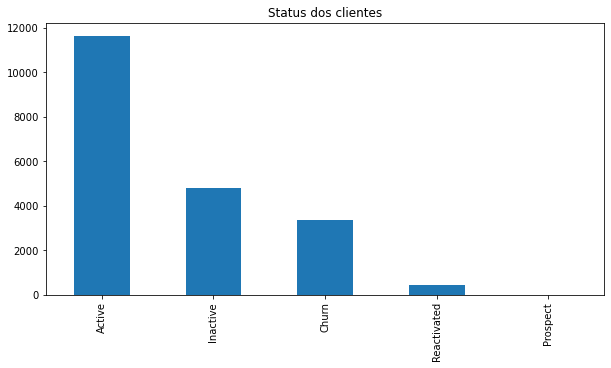

In [9]:
# Verificando a distribuição da variável ifood_status
print(marketing.ifood_status.value_counts())

f, ax = plt.subplots(figsize=(10, 5))
marketing.ifood_status.value_counts().plot(kind='bar', title="Status dos clientes", ax=ax, figsize=(10,5))
plt.show()

In [10]:
#Verificando percentual das classes dos status dos clientes
print('Ativo', round(
        marketing.ifood_status.value_counts()['Active']/len(marketing.ifood_status)*100, 2), '% dos clientes')
print('Inativo', round(
        marketing.ifood_status.value_counts()['Inactive']/len(marketing.ifood_status)*100, 2), '% dos clientes')
print('Churn', round(
        marketing.ifood_status.value_counts()['Churn']/len(marketing.ifood_status)*100, 2), '% dos clientes')
print('Reativado', round(
        marketing.ifood_status.value_counts()['Reactivated']/len(marketing.ifood_status)*100, 2), '% dos clientes')
print('Prospecção', round(
        marketing.ifood_status.value_counts()['Prospect']/len(marketing.ifood_status)*100, 2), '% dos clientes')

Ativo 57.52 % dos clientes
Inativo 23.73 % dos clientes
Churn 16.57 % dos clientes
Reativado 2.17 % dos clientes
Prospecção 0.0 % dos clientes


A maioria dos clientes estão ativos (mais de 50%), mas temos uma quantidade considerável de inativos e churn.

Active         14080
Inactive        4583
Reactivated      922
Churn            662
New                1
Prospect           1
Name: ifood_status_last_month, dtype: int64


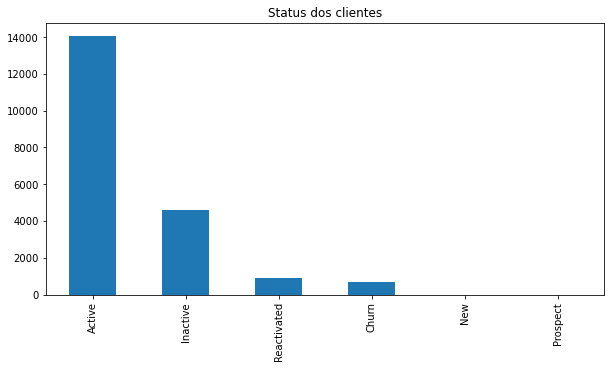

In [11]:
# Verificando a distribuição da variável ifood_status do mês passado
print(marketing.ifood_status_last_month.value_counts())

f, ax = plt.subplots(figsize=(10, 5))
marketing.ifood_status_last_month.value_counts().plot(kind='bar', title="Status dos clientes", ax=ax, figsize=(10,5))
plt.show()

In [12]:
#Verificando percentual das classes dos status dos clientes
print('Ativo', round(
        marketing.ifood_status_last_month.value_counts()['Active']/len(marketing.ifood_status)*100, 2), '% dos clientes')
print('Inativo', round(
        marketing.ifood_status_last_month.value_counts()['Inactive']/len(marketing.ifood_status)*100, 2), '% dos clientes')
print('Churn', round(
        marketing.ifood_status_last_month.value_counts()['Churn']/len(marketing.ifood_status)*100, 2), '% dos clientes')
print('Reativado', round(
        marketing.ifood_status_last_month.value_counts()['Reactivated']/len(marketing.ifood_status)*100, 2), '% dos clientes')
print('Prospecção', round(
        marketing.ifood_status_last_month.value_counts()['Prospect']/len(marketing.ifood_status)*100, 2), '% dos clientes')
print('Novos', round(
        marketing.ifood_status_last_month.value_counts()['New']/len(marketing.ifood_status)*100, 2), '% dos clientes')

Ativo 69.53 % dos clientes
Inativo 22.63 % dos clientes
Churn 3.27 % dos clientes
Reativado 4.55 % dos clientes
Prospecção 0.0 % dos clientes
Novos 0.0 % dos clientes


Se considerarmos o último mês, a quantidade de churn é menor. 

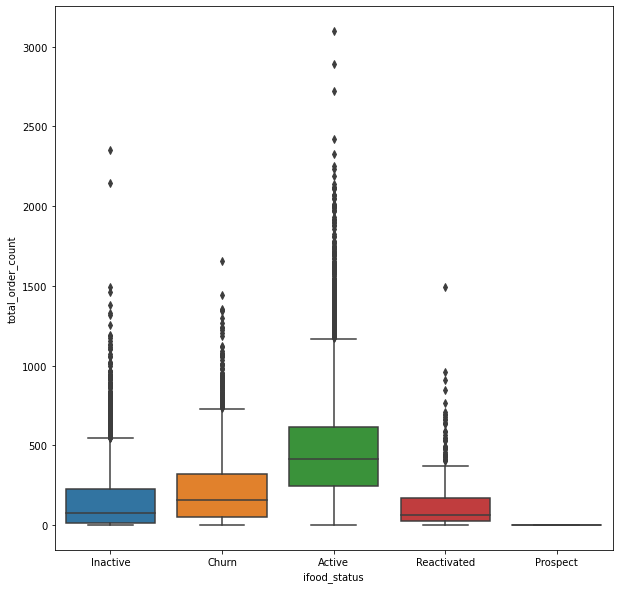

In [13]:
# Distribuicao da variável status do cliente com quantidade de pedidos
plt.figure(figsize=(10,10))
sns.boxplot(data=marketing, x='ifood_status', y='total_order_count')
plt.show()

Os clientes ativos são os que mais possuem pedidos, mas há muitos outliers nos dados. Vamos verificar há quando tempo os clientes estão na plataforma.

In [14]:
from datetime import date, time, datetime, timedelta
from dateutil.relativedelta import relativedelta

In [15]:
#Criando data
str_date = '2021/01/10'
ano = pd.to_datetime(str_date)
print(ano, type(ano))

2021-01-10 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [16]:
#Passando a coluna de interesse para formato data
marketing['primeiro_pedido'] = pd.to_datetime(marketing['first_order_date'])

In [17]:
#Verificando a transformação
marketing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20249 entries, 0 to 20248
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   account_id               20249 non-null  object        
 1   registration_date        20249 non-null  object        
 2   ifood_status             20249 non-null  object        
 3   ifood_status_last_month  20249 non-null  object        
 4   total_order_count        20249 non-null  int64         
 5   first_order_date         20248 non-null  object        
 6   primeiro_pedido          20248 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.7+ MB


In [18]:
#Criando a feature tempo de utilização do aplicativo 
marketing['utilizacao_ifood'] = (ano - marketing['primeiro_pedido']).dt.days
marketing

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date,primeiro_pedido,utilizacao_ifood
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28,2020-02-28,317.0
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19,2017-03-19,1393.0
2,61c051ee-d37c-45c6-8c22-c236db3b62b7,2018-09-02,Active,Active,206,2018-09-02,2018-09-02,861.0
3,82e48692-e4fa-494e-b03e-6815a819b7b1,2017-11-10,Reactivated,Churn,47,2018-05-01,2018-05-01,985.0
4,382af025-14c8-4ba9-b62f-deddd6f25789,2019-08-05,Inactive,Inactive,66,2019-08-12,2019-08-12,517.0
...,...,...,...,...,...,...,...,...
20244,43ca9ecf-4a84-46c0-bddc-08500cc2dadd,2015-08-03,Inactive,Inactive,1186,2015-08-17,2015-08-17,1973.0
20245,bba67e7e-6760-4f0d-846c-b85af925acf1,2019-03-17,Inactive,Inactive,4,2019-12-11,2019-12-11,396.0
20246,d0ceeec4-3cc6-4878-acf9-a0f4aeb95f66,2020-01-07,Inactive,Inactive,2,2020-02-13,2020-02-13,332.0
20247,e0ec291a-cd2f-428a-a6ab-5f88b5d141dd,2017-08-12,Inactive,Inactive,263,2017-08-12,2017-08-12,1247.0


In [19]:
marketing['total_order_count'] = marketing['total_order_count'].astype(float)

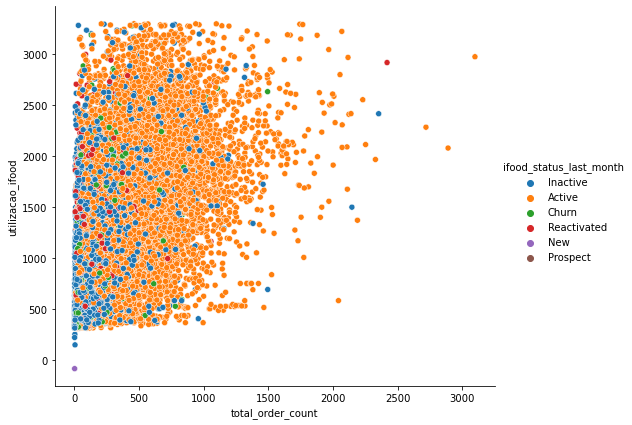

In [20]:
#Verificando a relação entre números de pedidos e temp ode utilização da plataforma
sns.relplot(data=marketing, x='total_order_count', y='utilizacao_ifood', kind='scatter', height=6, aspect=1.2, hue='ifood_status_last_month')

Clientes ativos fazem pedidos quase todos os dias (?)

In [21]:
marketing.describe(percentiles = [.25, .5, .75, .90, .95, .99])

,total_order_count,utilizacao_ifood
count,20249.000000,20248.000000
mean,341.321201,1262.827983
std,303.150112,687.323177
min,0.000000,-80.000000
25%,91.000000,666.000000
50%,286.000000,1192.000000
75%,501.000000,1765.000000
90%,736.000000,2208.000000
95%,900.000000,2513.000000
99%,1329.040000,2984.060000


99% do total de pedidos são até 1329 pedidos. os demais podem ser erros. No gráfico acima é possível ver que há cliente com 2000 e 1500 pedidos em aproximadamente 500 dias, o que daria 3/4 pedidos por dia (erro?)

In [22]:
marketing[marketing.total_order_count > 2000][:20]

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date,primeiro_pedido,utilizacao_ifood
1231,e65a2c84-71dd-4d5b-aace-e9962a98e860,2015-05-03,Active,Active,2890.0,2015-05-02,2015-05-02,2080.0
2329,36313b2e-b6ed-434a-89b3-2426bf70205e,2014-06-06,Active,Active,2123.0,2014-06-06,2014-06-06,2410.0
3040,6d47b779-76cc-42ed-bef4-d54f4c9547f9,2015-03-29,Active,Active,2252.0,2015-03-29,2015-03-29,2114.0
4770,2e2b5376-c884-4109-bc35-50e50e33ea11,2015-04-21,Active,Active,2108.0,2015-04-21,2015-04-21,2091.0
4774,2fdd220e-104f-4f7f-8f7e-adfebf81a217,2014-10-10,Active,Active,2719.0,2014-10-10,2014-10-10,2284.0
5166,6fe87574-3d5b-4f93-88cd-36b79b619b18,2015-08-22,Active,Active,2328.0,2015-08-22,2015-08-22,1968.0
5958,18691f12-a38e-428a-b269-d3c88310d31f,2012-11-26,Active,Active,2116.0,2012-11-26,2012-11-26,2967.0
6218,3f972a09-c056-4742-ba4a-d95bc61f2155,2017-04-09,Active,Active,2189.0,2017-04-08,2017-04-08,1373.0
6223,403c76d9-09ae-4df7-85b8-9989b62d7230,2015-09-15,Active,Active,2001.0,2015-10-16,2015-10-16,1913.0
7616,678f7794-80d5-40ea-a6a7-753cf1a89e89,2013-05-24,Inactive,Inactive,2353.0,2014-05-31,2014-05-31,2416.0


Alguns dos clientes fizeram mais de um pedido por dia. Isso pode ser justificado se a pessoa faz pedido para almoço e para janta. Deixaremos os dados no dataset.

### Orders

In [23]:
dadosorders = pd.read_csv("orders1.csv")
orders = dadosorders[:]

In [24]:
pd.set_option('display.max_columns', None)
orders

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at;;
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.00,False,5375.0,0.0,ANDROID,MOBILE,9.39.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,83c3e069dbd7267a7565a16b879cd968c0968a27ac16e6...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.38,RJ,RIO DE JANEIRO,PAVUNA,21650420.0,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-02-28T19:06:31.861Z;;
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.00,False,2987.5,1250.0,IOS,MOBILE,9.63.0,-22.93-43.18,RJ,RIO DE JANEIRO,FLAMENGO,-43.18,-22.94,2531d200d387f462ed6e096086723c43b48de9b6c3ec05...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.93-43.21,RJ,RIO DE JANEIRO,Rio Comprido,20261170.0,-43.22,-22.93,True,2020-08-21T21:12:23.295Z,2020-08-21T21:59:18.732Z,1.0,407bab9f-f485-48cd-abea-66e6283058c3,5.0,8.0,2020-09-04T00:14:14.365Z;;
2,00214248-5a2d-4333-a919-c1f3afd31389,weekday dinner,RESTAURANT,0.00,False,3737.5,2123.75,IOS,MOBILE,9.56.0,-23.6-46.64,SP,SAO PAULO,Vila Clementino,-46.65,-23.60,e648c3eeabfbbc52d415e4f2b4bb07ed0206c7fff7fb9c...,Comida Peruana,5384e3b557315ce815e7e3425a4d067f1ecff96978501e...,-23.61-46.67,SP,SAO PAULO,INDIANOPOLIS,4029200.0,-46.67,-23.62,True,2020-07-02T20:21:51.900Z,2020-07-02T20:53:39.176Z,3.0,a16865d2-a3ca-4251-afab-083dadeb06e9,5.0,5.0,2020-07-03T03:49:03.214Z;;
3,007199e6-6be4-42d0-986c-a0de7650dc80,weekday dinner,RESTAURANT,862.50,False,2237.5,1.25,DESKTOP,SITE,8.39.0,-22.96-43.39,RJ,RIO DE JANEIRO,Curicica,-43.39,-22.96,c3b2f2bc35b781c126ab4e78db73aa5609e55b1eff34c8...,Pizza,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.96-43.4,RJ,RIO DE JANEIRO,Curicica,22780193.0,-43.40,-22.96,False,2020-08-19T20:16:16.718Z,2020-08-19T22:16:16.298Z,0.0,a7f00fd8-d5d6-4604-9bce-ffe35b16848d,5.0,10.0,2020-08-26T17:44:08.137Z;;
4,00bb6d10-0a9b-4fe3-9b25-8d18f50bcc3a,weekday lunch,RESTAURANT,0.00,False,2750.0,0.0,DESKTOP,SITE,8.12.0,-23.57-46.64,SP,SAO PAULO,Liberdade,-46.64,-23.57,63271292b131c157593c309acfcbcd5756ec1440879e64...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.59-46.64,SP,SAO PAULO,Vila Mariana,4009002.0,-46.64,-23.59,True,2020-04-15T13:01:55.231Z,2020-04-15T17:02:37.723Z,1.0,63284037-3ade-4600-88e9-5009b9504d8f,5.0,10.0,2020-04-17T22:05:13.983Z;;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226264,fe810a8e-97be-4a85-a6c0-eb446fd72fd9,weekend dawn,RESTAURANT,375.00,False,10437.5,0.0,IOS,MOBILE,9.52.0,-22.95-43.34,RJ,RIO DE JANEIRO,ANIL,-43.34,-22.95,d07d54994d14abe915f1fd678ed66284d6810d60344536...,Lanches,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.95-43.36,RJ,RIO DE JANEIRO,Cidade de Deus,22763011.0,-43.36,-22.95,False,2020-05-31T01:12:22.097Z,2020-05-31T03:23:49.538Z,2.0,f415e4e7-097a-4b32-8fb9-6361658db37b,5.0,10.0,2020-05-31T06:24:22.437Z;;
226265,feb7b532-9602-4623-b89d-32697a0b6e17,weekday breakfast,RESTAURANT,873.75,False,6348.75,0.0,ANDROID,MOBILE,9.56.0,-23.6-46.61,SP,SAO PAULO,Vila Nair,-46.61,-23.61,70f36e5a2493ada1c021b99241012501a241d946c2564a...,Padaria,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.58-46.61,SP,SAO PAULO,Ipiranga,4205001.0,-46.61,-23.59,False,2020-06-30T08:27:56.247Z,2020-06-30T08:51:08.729Z,1.0,d03e5849-703e-4e49-a051-7a5d652c3b28,5.0,10.0,2020-06-30T17:13:24.936Z;;
226266,ff54b0d0-6bd3-4bad-a34c-ec64f0b17787,weekday dinner,RESTAURANT,875.00,False,8512.5

In [25]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              226269 non-null  object 
 1   order_shift           221634 non-null  object 
 2   order_origin          221634 non-null  object 
 3   delivery_fee          221634 non-null  float64
 4   scheduled             221634 non-null  object 
 5   total_amount          221634 non-null  object 
 6   subsidy_amount        221634 non-null  object 
 7   device_platform       221634 non-null  object 
 8   device_type           221634 non-null  object 
 9   device_app_version    221634 non-null  object 
 10  centroid_id           221634 non-null  object 
 11  state_label           221634 non-null  object 
 12  city                  221633 non-null  object 
 13  district              221633 non-null  object 
 14  customer_long         221633 non-null  float64
 15  

In [26]:
orders.isnull().sum() #Muitos valores nulos, excluir

order_id                   0
order_shift             4635
order_origin            4635
delivery_fee            4635
scheduled               4635
total_amount            4635
subsidy_amount          4635
device_platform         4635
device_type             4635
device_app_version      4635
centroid_id             4635
state_label             4635
city                    4636
district                4636
customer_long           4636
customer_lat            4636
restaurant_id           4636
dish_type               4636
group_id                4636
merchant_centroid_id    4636
merchant_state          4636
merchant_city           4636
merchant_district       4636
merchant_zipcode        4636
merchant_long           4636
merchant_lat            4636
has_free_delivery       4636
confirmed_date          4636
concluded_date          4636
lag_last_order          4636
account_id              4636
review_score            4636
nps_score               4636
review_created_at;;     4636
dtype: int64

In [27]:
#Excluindo linhas onde todos os valores são nulos
orders = orders.dropna(thresh=33)

In [28]:
226269-221633 #Comando acima excluiu dados faltantes em orders, que eram linhas completas

4636

In [29]:
orders.isnull().sum()

order_id                0
order_shift             0
order_origin            0
delivery_fee            0
scheduled               0
total_amount            0
subsidy_amount          0
device_platform         0
device_type             0
device_app_version      0
centroid_id             0
state_label             0
city                    0
district                0
customer_long           0
customer_lat            0
restaurant_id           0
dish_type               0
group_id                0
merchant_centroid_id    0
merchant_state          0
merchant_city           0
merchant_district       0
merchant_zipcode        0
merchant_long           0
merchant_lat            0
has_free_delivery       0
confirmed_date          0
concluded_date          0
lag_last_order          0
account_id              0
review_score            0
nps_score               0
review_created_at;;     0
dtype: int64

In [30]:
# Verificando se há variáveis duplicadas
orders.shape

(221633, 34)

In [31]:
orders.drop_duplicates(keep=False, inplace=True)

In [32]:
orders.shape #Não haviam dados duplicados

(221633, 34)

Conhecendo a distribuição de algumas categorias.

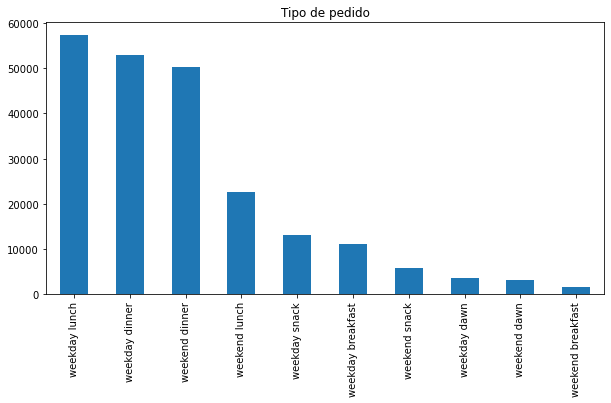

In [33]:
f, ax = plt.subplots(figsize=(10, 5))
orders.order_shift.value_counts().plot(kind='bar', title="Tipo de pedido", ax=ax, figsize=(10,5))
plt.show()

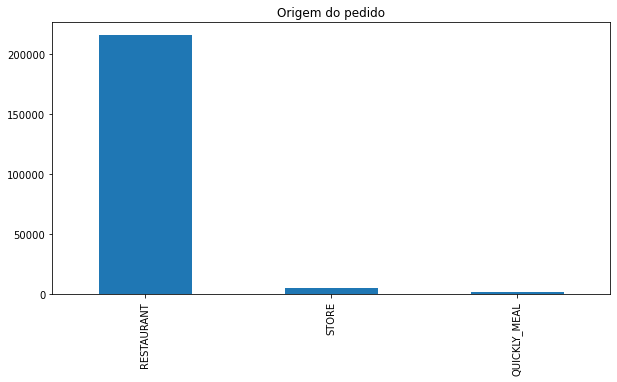

In [34]:
f, ax = plt.subplots(figsize=(10, 5))
orders.order_origin.value_counts().plot(kind='bar', title="Origem do pedido", ax=ax, figsize=(10,5))
plt.show()

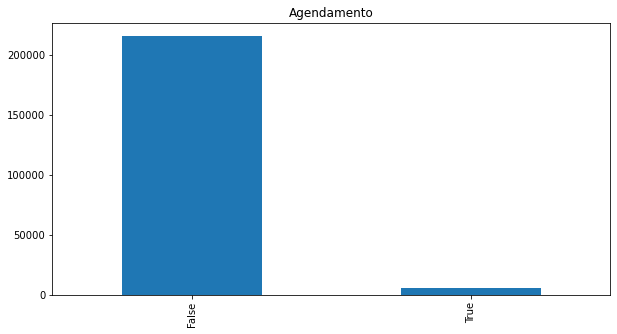

In [35]:
f, ax = plt.subplots(figsize=(10, 5))
orders.scheduled.value_counts().plot(kind='bar', title="Agendamento", ax=ax, figsize=(10,5))
plt.show()

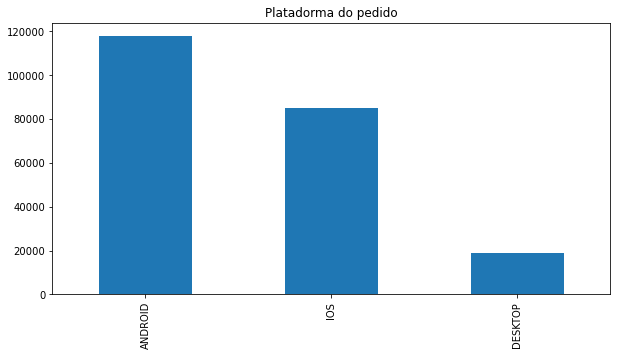

In [36]:
f, ax = plt.subplots(figsize=(10, 5))
orders.device_platform.value_counts().plot(kind='bar', title="Platadorma do pedido", ax=ax, figsize=(10,5))
plt.show()

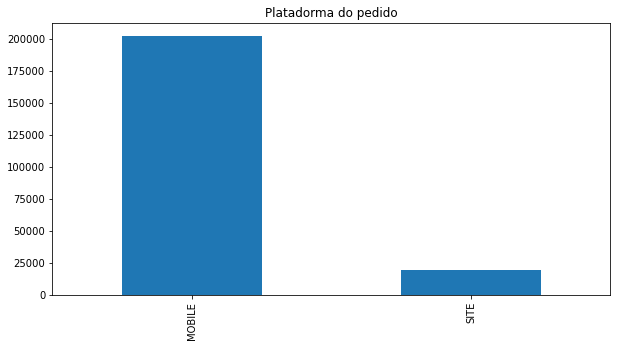

In [37]:
f, ax = plt.subplots(figsize=(10, 5))
orders.device_type.value_counts().plot(kind='bar', title="Platadorma do pedido", ax=ax, figsize=(10,5))
plt.show()

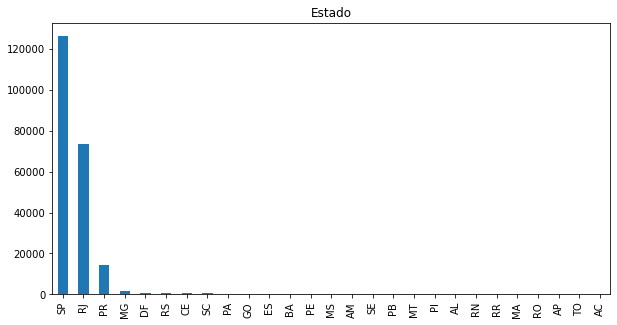

In [38]:
f, ax = plt.subplots(figsize=(10, 5))
orders.state_label.value_counts().plot(kind='bar', title="Estado", ax=ax, figsize=(10,5))
plt.show()

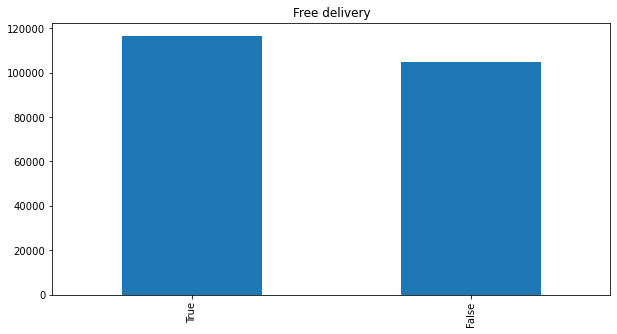

In [39]:
f, ax = plt.subplots(figsize=(10, 5))
orders.has_free_delivery.value_counts().plot(kind='bar', title="Free delivery", ax=ax, figsize=(10,5))
plt.show()

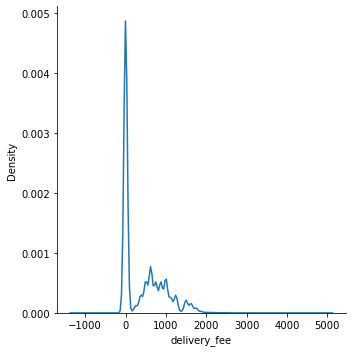

In [40]:
sns.displot(orders["delivery_fee"], kind='kde')

delivery_fee é a taxa de entrega paga pelo cliente. Como visto no gráfico acima, mais da metade das entregas é grátis, justificando o pico em zero. Os demais valores devem estar em centavos, o que justifica um valor tão alto. 

In [41]:
#Converter variáveis que estão em centavos para reais
orders['delivery_fee'] = orders['delivery_fee']/100

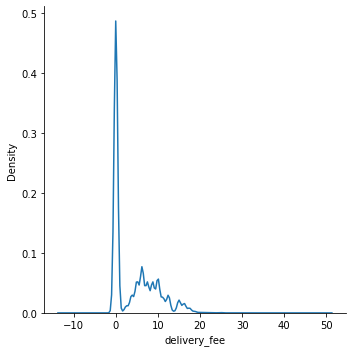

In [42]:
sns.displot(orders["delivery_fee"], kind='kde')

Agora os valores estão mais condizentes, com taxa de entregas predominando entre 10 e 20 reais, e não ultrapassando 50 reais.

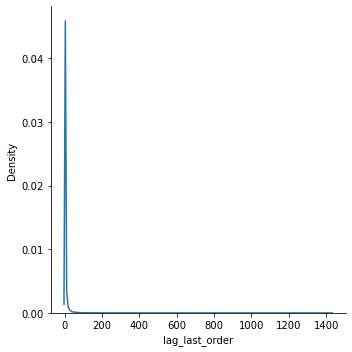

In [43]:
sns.displot(orders["lag_last_order"], kind='kde')

A variável lag_last_order refere-se ao tempo entre o atual e último pedido. Aqui é possível ver que esse período está quase todo em 0/1, confirmando que muitos clientes fazem pedidos todos os dias (como mostra o dataset marketing).

In [44]:
#convertendo total_amount de objeto para float
orders['total_amount'] = orders['total_amount'].astype(float)

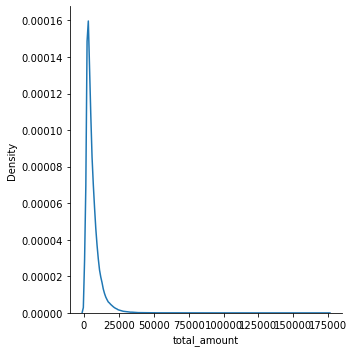

In [45]:
sns.displot(orders["total_amount"], kind='kde')

Aqui também temos valores muitos altos, iremos transformar em reais.

In [46]:
#Converter variáveis que estão em centavos para reais
orders['total_amount'] = orders['total_amount']/100

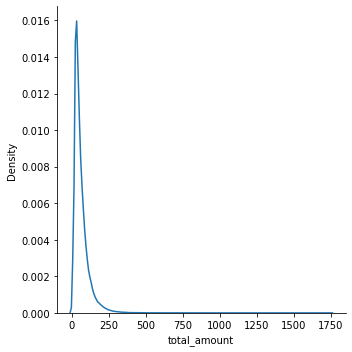

In [47]:
sns.displot(orders["total_amount"], kind='kde')

Pedidos com valor zero não fazem sentido (ou são uma promoção?). Demais pedidos estão condizentes agora.

In [48]:
orders.describe(percentiles = [.25, .5, .75, .90, .95, .99])

,delivery_fee,total_amount,customer_long,customer_lat,merchant_zipcode,merchant_long,merchant_lat,lag_last_order,review_score,nps_score
count,221633.000000,221633.000000,221633.000000,221633.000000,2.216330e+05,221633.000000,221633.000000,221633.000000,221633.000000,221633.000000
mean,4.080909,60.753055,-45.689116,-23.187974,1.709253e+07,-45.689056,-23.188744,2.533337,4.660759,9.093700
std,5.048729,52.022200,2.194990,2.227471,2.108466e+07,2.205809,2.227500,12.094645,0.935141,1.908111
min,-12.475000,0.000000,-67.870000,-31.780000,0.000000e+00,-67.840000,-31.780000,0.000000,1.000000,1.000000
25%,0.000000,28.625000,-46.700000,-23.600000,4.048000e+06,-46.700000,-23.600000,0.000000,5.000000,9.000000
50%,0.000000,46.000000,-46.620000,-23.530000,6.773290e+06,-46.620000,-23.530000,1.000000,5.000000,10.000000
75%,7.500000,76.237500,-43.350000,-22.940000,2.222101e+07,-43.350000,-22.940000,2.000000,5.000000,10.000000
90%,11.237500,119.625000,-43.200000,-22.890000,2.726002e+07,-43.210000,-22.890000,5.000000,5.000000,10.000000
95%,14.875000,155.930000,-43.190000,-22.820000,8.042001e+07,-43.190000,-22.820000,8.000000,5.000000,10.000000
99%,17.487500,253.737500,-41.310000,-8.770000,8.332451e+07,-41.300000,-8.770000,27.000000,5.000000,10.000000


- delivery_fee com valor negativo, não faz sentido
- total_amount com zero, pode ser uma promoção (?)
- total_amount que é o total pago possui uma média de 50 com desvio padrão de 52. Aqui, 75% dos valores estão abaixo de 76, e aproximadamente 10% dos valores bem distantes da média e mediana.

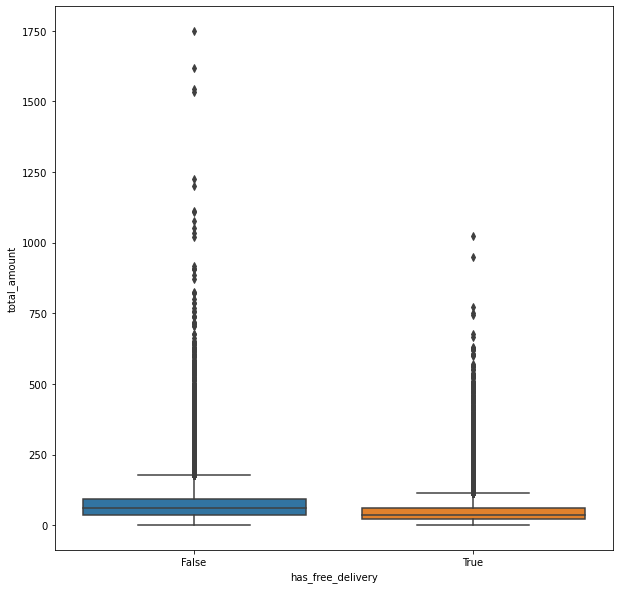

In [49]:
# Distribuicao da variável free delivery com o total gasto no pedido
plt.figure(figsize=(10,10))
sns.boxplot(data=orders, x='has_free_delivery', y='total_amount')
plt.show()

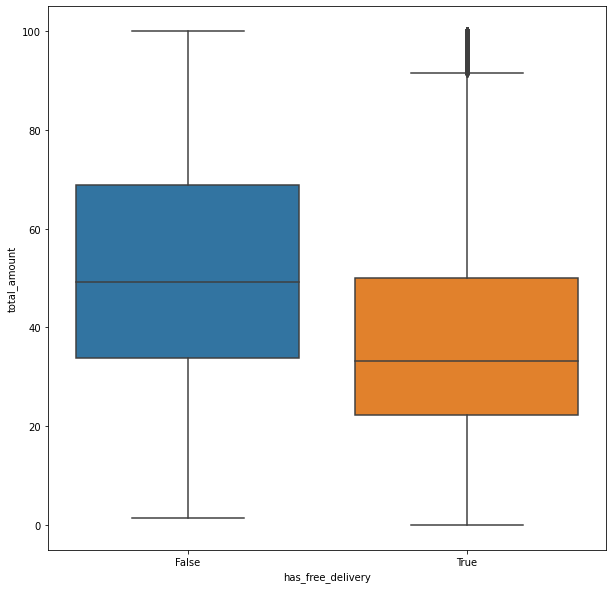

In [50]:
# Distribuicao da variável free delivery com o total gasto no pedido
plt.figure(figsize=(10,10))
sns.boxplot(data=orders[orders.total_amount < 1e2], x='has_free_delivery', y='total_amount')
plt.show()

Clientes com free delivery tendem a ter um ticket de valor menor.

### Sessions

In [51]:
dadossessions = pd.read_csv("sessions.csv", sep=';')
sessions = dadossessions[:]

In [52]:
sessions

,session_id,user_account_uuid,session_started,session_ended,install_timestamp,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,first_order_has_voucher,media_campaign,load_time,available_restaurants,rownumber
0,0a364c77-4375-4334-8f64-a06bdd22229c,5a2fbdea-e2ee-41a5-b47c-41fbebdc78ef,2020-02-01T00:00:03.924Z,2020-02-01T00:10:51.217Z,NaN,19,5,6,6,7,False,NaN,5.0,462.0,1
1,b01811cd-ad2c-42f1-bccf-b90698ccc7a8,20cb43a7-c90d-4451-b067-e1b934746de6,2020-02-01T00:00:09.616Z,2020-02-01T00:14:22.713Z,NaN,14,1,0,0,0,NaN,NaN,5.0,128.0,2
2,aa453bd1-da47-4cfa-9ce7-a7e2c9227dec,b6bd9094-c2f0-471c-b6ec-9475d8d0591b,2020-02-01T00:00:14.479Z,2020-02-01T00:08:20.102Z,NaN,31,4,4,3,1,False,NaN,6.0,187.0,3
3,39ca6d98-c9d1-4dff-9158-c7416be6d309,d7ddb2ac-31bf-4e3d-848a-9efc86a70f6d,2020-02-01T00:00:14.650Z,2020-02-01T00:02:49.615Z,NaN,12,3,0,0,0,NaN,NaN,5.0,22.0,4
4,cf456658-0426-46c2-b6c1-fc27c186e15e,8d9bb514-cc57-4181-bb9d-b94b7fbbfd98,2020-02-01T00:00:41.607Z,2020-02-01T00:16:57.415Z,NaN,4,0,0,0,0,NaN,NaN,28.0,3.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591506,85770037-9a5c-4ac3-8ba3-ae2b83135e73,9b8c5cb4-837d-4457-bf66-ac1ecdf108cd,2020-09-30T23:59:29.388Z,2020-10-01T00:00:18.295Z,NaN,6,1,1,1,0,NaN,NaN,4.0,220.0,3591507
3591507,45072446-a0cd-4747-8de9-07875633c5e0,9eb99387-ee18-4930-801b-b7201ae46df9,2020-09-30T23:59:37.159Z,2020-10-01T00:44:50.978Z,NaN,3,1,1,2,2,NaN,NaN,3.0,460.0,3591508
3591508,871c9936-e287-439b-88e5-f85e9fdde177,23aeed54-ec20-448f-8857-d321c18cf411,2020-09-30T23:59:40.218Z,2020-10-01T00:01:49.361Z,NaN,0,0,0,0,0,NaN,NaN,4.0,241.0,3591509
3591509,bda71adc-50bb-48bd-82cc-647174b3bfa5,4b8bc8a5-cf2d-4d77-bea9-64ed735fe4ec,2020-09-30T23:59:51.837Z,2020-10-01T00:01:56.597Z,NaN,2,0,0,0,0,NaN,NaN,3.0,14.0,3591510


In [53]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591511 entries, 0 to 3591510
Data columns (total 15 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   session_id                  object 
 1   user_account_uuid           object 
 2   session_started             object 
 3   session_ended               object 
 4   install_timestamp           object 
 5   sum_view_restaurant_screen  int64  
 6   sum_view_dish_screen        int64  
 7   sum_click_add_item          int64  
 8   sum_view_checkout           int64  
 9   sum_callback_purchase       int64  
 10  first_order_has_voucher     object 
 11  media_campaign              object 
 12  load_time                   float64
 13  available_restaurants       float64
 14  rownumber                   int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 411.0+ MB


In [54]:
sessions.isnull().mean().round(4)*100 #Maioria dos dados faltantes em primeira instalação do app após setup, se utilizado voucher no primeiro
#pedido, se a sessão foi iniciada por campanha de mídia. Muitos dados faltantes também em horário do término da sessão e tempo
#de carregamento inicial da sessão. Iremos remover essas variáveis.

session_id                     0.00
user_account_uuid              0.00
session_started                0.00
session_ended                  1.27
install_timestamp             99.68
sum_view_restaurant_screen     0.00
sum_view_dish_screen           0.00
sum_click_add_item             0.00
sum_view_checkout              0.00
sum_callback_purchase          0.00
first_order_has_voucher       88.29
media_campaign                98.51
load_time                     20.70
available_restaurants          0.00
rownumber                      0.00
dtype: float64

In [55]:
sessions.drop(["install_timestamp", "first_order_has_voucher", "media_campaign"], axis=1, inplace=True)

In [56]:
#Verificando dados duplicados
sessions.shape

(3591511, 12)

In [57]:
sessions.drop_duplicates(keep=False, inplace=True)

In [58]:
sessions.shape #Não haviam dados duplicados

(3591511, 12)

In [59]:
sessions.isnull().mean().round(4)*100

session_id                     0.00
user_account_uuid              0.00
session_started                0.00
session_ended                  1.27
sum_view_restaurant_screen     0.00
sum_view_dish_screen           0.00
sum_click_add_item             0.00
sum_view_checkout              0.00
sum_callback_purchase          0.00
load_time                     20.70
available_restaurants          0.00
rownumber                      0.00
dtype: float64

In [60]:
sessions.describe()

,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,load_time,available_restaurants,rownumber
count,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06,2.848111e+06,3.591511e+06,3.591511e+06
mean,6.541976e+00,3.401753e+00,1.613600e+00,2.015747e+00,7.375651e-01,3.995431e+01,1.161834e+03,1.795756e+06
std,1.290502e+01,6.024095e+00,2.866229e+00,4.228897e+00,2.103870e+00,1.019375e+03,1.121173e+03,1.036780e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.597200e+04,0.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.240000e+02,8.978785e+05
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,8.310000e+02,1.795756e+06
75%,8.000000e+00,4.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,6.000000e+00,1.650000e+03,2.693634e+06
max,2.612000e+03,6.350000e+02,3.020000e+02,4.220000e+02,6.810000e+02,1.120474e+06,6.149000e+03,3.591511e+06


In [61]:
sessions['session_started'] = pd.to_datetime(sessions['session_started'])
sessions['session_ended'] = pd.to_datetime(sessions['session_ended'])

In [62]:
sessions['tempo_app'] = (sessions['session_ended'] - sessions['session_started']).dt.seconds
sessions

,session_id,user_account_uuid,session_started,session_ended,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,load_time,available_restaurants,rownumber,tempo_app
0,0a364c77-4375-4334-8f64-a06bdd22229c,5a2fbdea-e2ee-41a5-b47c-41fbebdc78ef,2020-02-01 00:00:03.924000+00:00,2020-02-01 00:10:51.217000+00:00,19,5,6,6,7,5.0,462.0,1,647.0
1,b01811cd-ad2c-42f1-bccf-b90698ccc7a8,20cb43a7-c90d-4451-b067-e1b934746de6,2020-02-01 00:00:09.616000+00:00,2020-02-01 00:14:22.713000+00:00,14,1,0,0,0,5.0,128.0,2,853.0
2,aa453bd1-da47-4cfa-9ce7-a7e2c9227dec,b6bd9094-c2f0-471c-b6ec-9475d8d0591b,2020-02-01 00:00:14.479000+00:00,2020-02-01 00:08:20.102000+00:00,31,4,4,3,1,6.0,187.0,3,485.0
3,39ca6d98-c9d1-4dff-9158-c7416be6d309,d7ddb2ac-31bf-4e3d-848a-9efc86a70f6d,2020-02-01 00:00:14.650000+00:00,2020-02-01 00:02:49.615000+00:00,12,3,0,0,0,5.0,22.0,4,154.0
4,cf456658-0426-46c2-b6c1-fc27c186e15e,8d9bb514-cc57-4181-bb9d-b94b7fbbfd98,2020-02-01 00:00:41.607000+00:00,2020-02-01 00:16:57.415000+00:00,4,0,0,0,0,28.0,3.0,5,975.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591506,85770037-9a5c-4ac3-8ba3-ae2b83135e73,9b8c5cb4-837d-4457-bf66-ac1ecdf108cd,2020-09-30 23:59:29.388000+00:00,2020-10-01 00:00:18.295000+00:00,6,1,1,1,0,4.0,220.0,3591507,48.0
3591507,45072446-a0cd-4747-8de9-07875633c5e0,9eb99387-ee18-4930-801b-b7201ae46df9,2020-09-30 23:59:37.159000+00:00,2020-10-01 00:44:50.978000+00:00,3,1,1,2,2,3.0,460.0,3591508,2713.0
3591508,871c9936-e287-439b-88e5-f85e9fdde177,23aeed54-ec20-448f-8857-d321c18cf411,2020-09-30 23:59:40.218000+00:00,2020-10-01 00:01:49.361000+00:00,0,0,0,0,0,4.0,241.0,3591509,129.0
3591509,bda71adc-50bb-48bd-82cc-647174b3bfa5,4b8bc8a5-cf2d-4d77-bea9-64ed735fe4ec,2020-09-30 23:59:51.837000+00:00,2020-10-01 00:01:56.597000+00:00,2,0,0,0,0,3.0,14.0,3591510,124.0


In [63]:
#Converter variáveis que estão em segundos para minutos
sessions['tempo_app'] = sessions['tempo_app']/60
sessions

,session_id,user_account_uuid,session_started,session_ended,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,load_time,available_restaurants,rownumber,tempo_app
0,0a364c77-4375-4334-8f64-a06bdd22229c,5a2fbdea-e2ee-41a5-b47c-41fbebdc78ef,2020-02-01 00:00:03.924000+00:00,2020-02-01 00:10:51.217000+00:00,19,5,6,6,7,5.0,462.0,1,10.783333
1,b01811cd-ad2c-42f1-bccf-b90698ccc7a8,20cb43a7-c90d-4451-b067-e1b934746de6,2020-02-01 00:00:09.616000+00:00,2020-02-01 00:14:22.713000+00:00,14,1,0,0,0,5.0,128.0,2,14.216667
2,aa453bd1-da47-4cfa-9ce7-a7e2c9227dec,b6bd9094-c2f0-471c-b6ec-9475d8d0591b,2020-02-01 00:00:14.479000+00:00,2020-02-01 00:08:20.102000+00:00,31,4,4,3,1,6.0,187.0,3,8.083333
3,39ca6d98-c9d1-4dff-9158-c7416be6d309,d7ddb2ac-31bf-4e3d-848a-9efc86a70f6d,2020-02-01 00:00:14.650000+00:00,2020-02-01 00:02:49.615000+00:00,12,3,0,0,0,5.0,22.0,4,2.566667
4,cf456658-0426-46c2-b6c1-fc27c186e15e,8d9bb514-cc57-4181-bb9d-b94b7fbbfd98,2020-02-01 00:00:41.607000+00:00,2020-02-01 00:16:57.415000+00:00,4,0,0,0,0,28.0,3.0,5,16.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591506,85770037-9a5c-4ac3-8ba3-ae2b83135e73,9b8c5cb4-837d-4457-bf66-ac1ecdf108cd,2020-09-30 23:59:29.388000+00:00,2020-10-01 00:00:18.295000+00:00,6,1,1,1,0,4.0,220.0,3591507,0.800000
3591507,45072446-a0cd-4747-8de9-07875633c5e0,9eb99387-ee18-4930-801b-b7201ae46df9,2020-09-30 23:59:37.159000+00:00,2020-10-01 00:44:50.978000+00:00,3,1,1,2,2,3.0,460.0,3591508,45.216667
3591508,871c9936-e287-439b-88e5-f85e9fdde177,23aeed54-ec20-448f-8857-d321c18cf411,2020-09-30 23:59:40.218000+00:00,2020-10-01 00:01:49.361000+00:00,0,0,0,0,0,4.0,241.0,3591509,2.150000
3591509,bda71adc-50bb-48bd-82cc-647174b3bfa5,4b8bc8a5-cf2d-4d77-bea9-64ed735fe4ec,2020-09-30 23:59:51.837000+00:00,2020-10-01 00:01:56.597000+00:00,2,0,0,0,0,3.0,14.0,3591510,2.066667


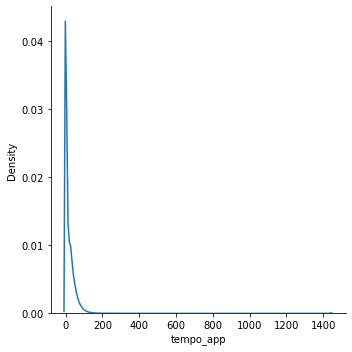

In [64]:
sns.displot(sessions["tempo_app"], kind='kde')

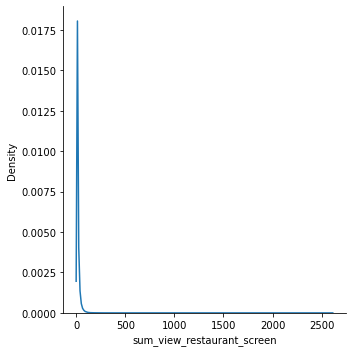

In [65]:
#Quantidades de restaurantes vistos
sns.displot(sessions["sum_view_restaurant_screen"], kind='kde')

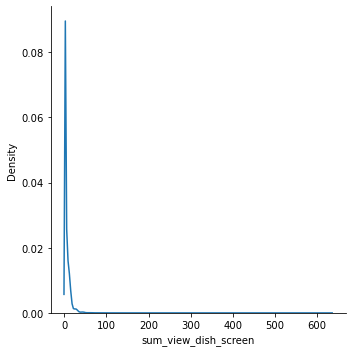

In [66]:
#Quantidades de pratos vistos
sns.displot(sessions["sum_view_dish_screen"], kind='kde')

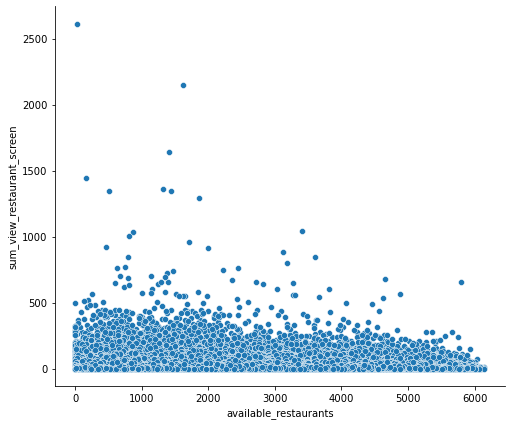

In [67]:
#Verificando a relação entrequantidade de restaurantes disponíveis e vistos
sns.relplot(data=sessions, x='available_restaurants', y='sum_view_restaurant_screen', kind='scatter', height=6, aspect=1.2)

In [ ]:
""" A princípio, não utilizaremos esse dataset
#Renomear coluna user_account_uuid de sessions para account_id para ser possível unir df
sessions = sessions.rename(columns={'user_account_uuid': 'account_id'}) 

##### Unindo datasets marketing e orders

In [69]:
marketing.reset_index(drop= True, inplace= True)

In [70]:
orders.reset_index(drop= True, inplace= True)

In [71]:
df = orders.merge(marketing, on = 'account_id', how = 'outer')

In [72]:
df.isna().sum()

order_id                   6388
order_shift                6388
order_origin               6388
delivery_fee               6388
scheduled                  6388
total_amount               6388
subsidy_amount             6388
device_platform            6388
device_type                6388
device_app_version         6388
centroid_id                6388
state_label                6388
city                       6388
district                   6388
customer_long              6388
customer_lat               6388
restaurant_id              6388
dish_type                  6388
group_id                   6388
merchant_centroid_id       6388
merchant_state             6388
merchant_city              6388
merchant_district          6388
merchant_zipcode           6388
merchant_long              6388
merchant_lat               6388
has_free_delivery          6388
confirmed_date             6388
concluded_date             6388
lag_last_order             6388
account_id                    0
review_s

In [73]:
#Excluindo linhas que ficaram com muitos nulos
df1 = df.dropna(thresh=33)

In [74]:
df1.isna().sum()

order_id                   0
order_shift                0
order_origin               0
delivery_fee               0
scheduled                  0
total_amount               0
subsidy_amount             0
device_platform            0
device_type                0
device_app_version         0
centroid_id                0
state_label                0
city                       0
district                   0
customer_long              0
customer_lat               0
restaurant_id              0
dish_type                  0
group_id                   0
merchant_centroid_id       0
merchant_state             0
merchant_city              0
merchant_district          0
merchant_zipcode           0
merchant_long              0
merchant_lat               0
has_free_delivery          0
confirmed_date             0
concluded_date             0
lag_last_order             0
account_id                 0
review_score               0
nps_score                  0
review_created_at;;        0
registration_d

In [75]:
#Convertendo o desconto dado no pedido para float
df1["subsidy_amount"] = df1["subsidy_amount"].astype(float)

In [76]:
#Converter variáveis que estão em centavos para reais
df1['subsidy_amount'] = df1['subsidy_amount']/100

In [77]:
df1

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at;;,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date,primeiro_pedido,utilizacao_ifood
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,8.7500,False,53.7500,0.0,ANDROID,MOBILE,9.39.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,83c3e069dbd7267a7565a16b879cd968c0968a27ac16e6...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.38,RJ,RIO DE JANEIRO,PAVUNA,21650420.0,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-02-28T19:06:31.861Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
1,137fb568-2756-408d-94ed-d67e011bd101,weekday lunch,RESTAURANT,5.0000,False,46.2500,0.0,ANDROID,MOBILE,9.61.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,caea67d70fc15b47f91313697d74218975c595332ad3c7...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.35,RJ,RIO DE JANEIRO,Pavuna,21532440.0,-43.36,-22.82,False,2020-08-05T12:04:11.975Z,2020-08-05T13:58:07.939Z,4.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-08-05T16:59:05.170Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
2,4605cdab-de39-45c8-81aa-deb752039354,weekday lunch,RESTAURANT,11.2500,False,72.5000,0.0,ANDROID,MOBILE,9.47.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,fb61026e05c21f18bbd85fb17112f7e39a67fb69a76285...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.3,RJ,RIO DE JANEIRO,Cordovil,21010180.0,-43.30,-22.82,False,2020-04-22T12:23:32.554Z,2020-04-22T14:41:57.633Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-04-22T18:28:34.009Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
3,2244c745-4b28-4544-bbd6-4e1101fda966,weekday lunch,RESTAURANT,9.9875,False,73.2125,0.0,ANDROID,MOBILE,9.47.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,a10244c99caff623e5d1df2ed3c60b718c1692892790c6...,Doces & Bolos,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.79-43.36,RJ,SAO JOAO DE MERITI,JARDIM JOSE BONIFACIO,25565370.0,-43.37,-22.79,False,2020-04-23T14:17:16.606Z,2020-04-23T14:52:40.470Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-04-24T03:15:23.114Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
4,f4ebb4d5-f4b6-4799-bd8a-5f77aaec8d71,weekend dinner,RESTAURANT,14.9875,False,56.2375,0.0,ANDROID,MOBILE,9.42.2,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,4a6ee271e930ff43ded123ac235b7ab305f75f9b12bc59...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.8-43.39,RJ,SAO JOAO DE MERITI,Tomazinho,25525520.0,-43.40,-22.81,False,2020-03-15T18:43:35.517Z,2020-03-15T19:37:59.175Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-03-16T02:24:28.095Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221628,72092f74-7366-4afe-9e74-d575d679cc01,weekend lunch,RESTAURANT,0.0000,False,27.5000,0.0,ANDROID,MOBILE,9.39.1,-23.63-46.61,SP,SAO PAULO,Vila Moraes,-46.61,-23.64,5f731c493c83b9f845d0d6fd846c4698e23300d8aeb578...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.63-46.62,SP,SAO PAULO,Vila Brasilina,4161070.0,-46.62,-23.64,True,2020-03-01T11:55:18.737Z,2020-03-01T13:55:18.201Z,7.0,1df4e2cf-07c8-4d82-b830-5aa33505bf2f,5.0,10.0,2020-03-15T19:54:48.660Z;;,2018-02-07,Inactive,Inactive,11.0,2018-02

## EDA do dataset completo

Active         182306
Inactive        27764
Churn            7064
Reactivated      4499
Name: ifood_status_last_month, dtype: int64


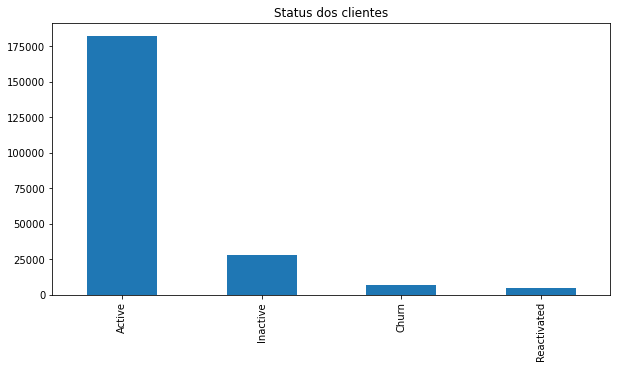

In [78]:
# Verificando a distribuição da variável ifood_status do mês passado
print(df1.ifood_status_last_month.value_counts())

f, ax = plt.subplots(figsize=(10, 5))
df1.ifood_status_last_month.value_counts().plot(kind='bar', title="Status dos clientes", ax=ax, figsize=(10,5))
plt.show()

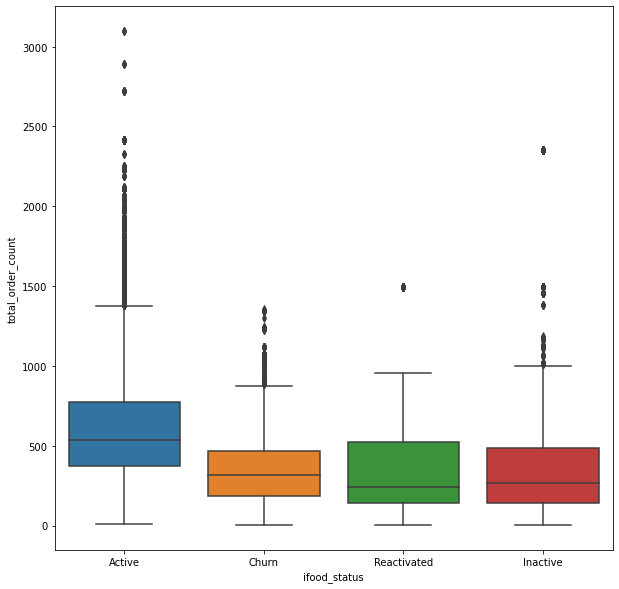

In [79]:
# Distribuicao da variável status do cliente com quantidade de pedidos
plt.figure(figsize=(10,10))
sns.boxplot(data=df1, x='ifood_status', y='total_order_count')
plt.show()

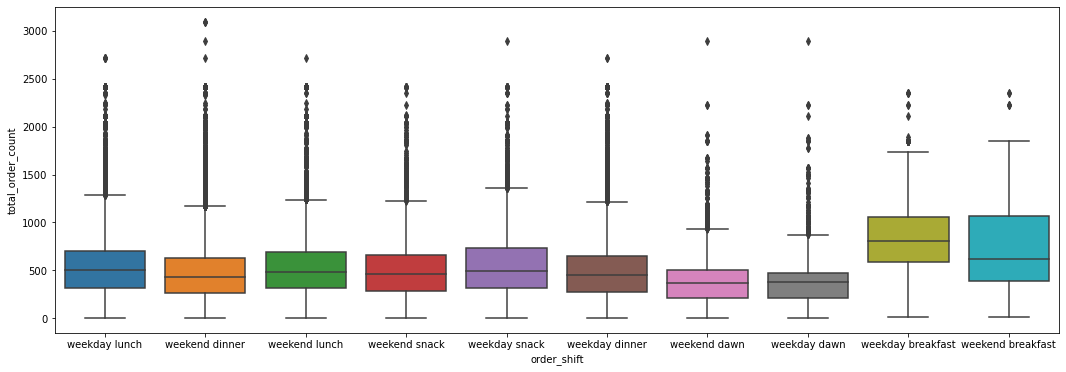

In [80]:
# Distribuicao da variável status do cliente com quantidade de pedidos
plt.figure(figsize=(18,6))
sns.boxplot(data=df1, x='order_shift', y='total_order_count')
plt.show()

Os maiores valores pedidos são no café da manhã.

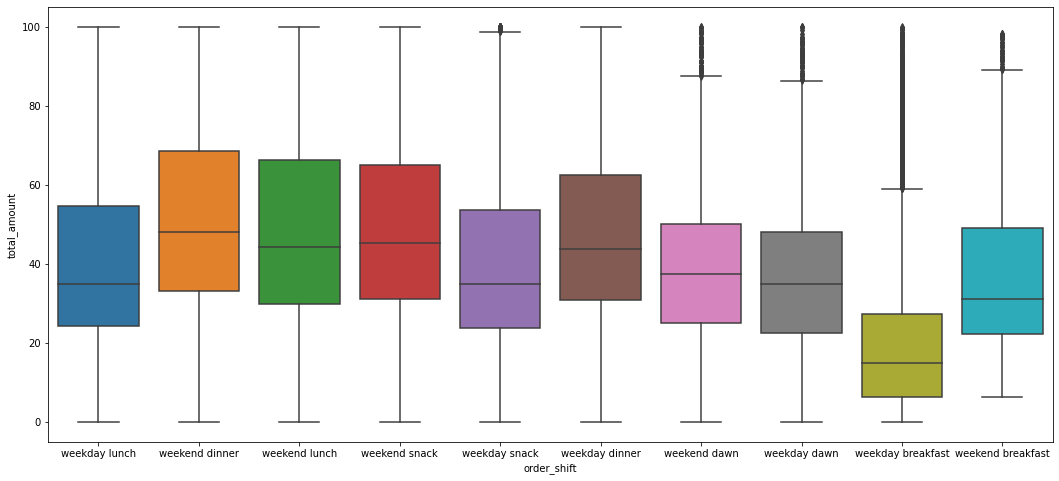

In [81]:
# Distribuicao da variável dia da semana com valor do pedido
plt.figure(figsize=(18,8))
sns.boxplot(data=df1[df1.total_amount < 1e2], x='order_shift', y='total_amount')
plt.show()

Os valores gastos não variam muito de acordo com o dia do pedido, apenas o café da manhã durante a semana tem valor menor.

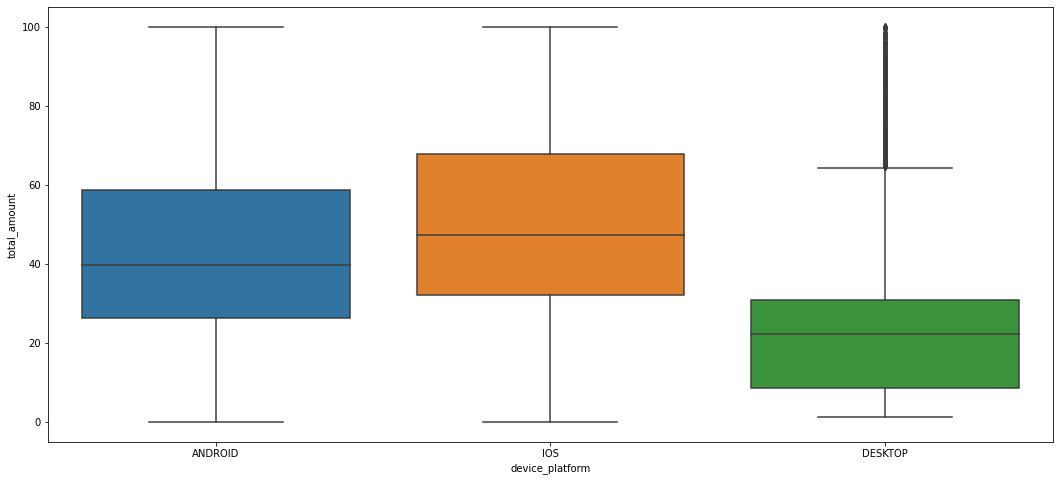

In [82]:
# Distribuicao da variável plataforma com valor do pedido
plt.figure(figsize=(18,8))
sns.boxplot(data=df1[df1.total_amount < 1e2], x='device_platform', y='total_amount')
plt.show()

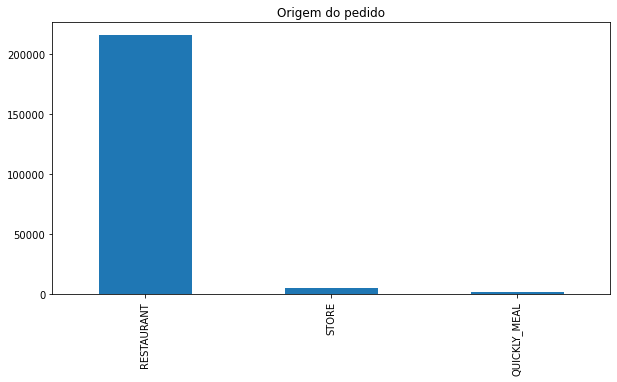

In [83]:
f, ax = plt.subplots(figsize=(10, 5))
df1.order_origin.value_counts().plot(kind='bar', title="Origem do pedido", ax=ax, figsize=(10,5))
plt.show()

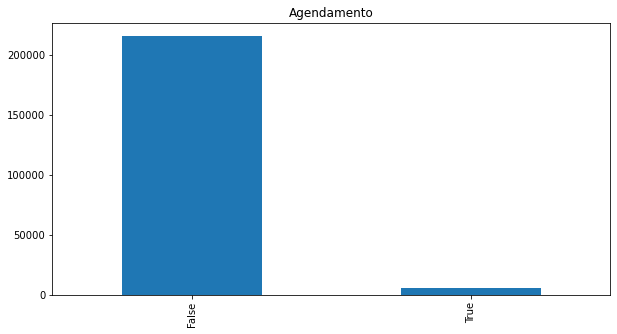

In [84]:
f, ax = plt.subplots(figsize=(10, 5))
df1.scheduled.value_counts().plot(kind='bar', title="Agendamento", ax=ax, figsize=(10,5))
plt.show()

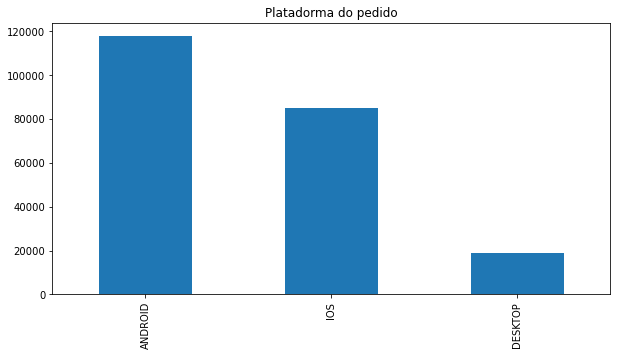

In [85]:
f, ax = plt.subplots(figsize=(10, 5))
df1.device_platform.value_counts().plot(kind='bar', title="Platadorma do pedido", ax=ax, figsize=(10,5))
plt.show()

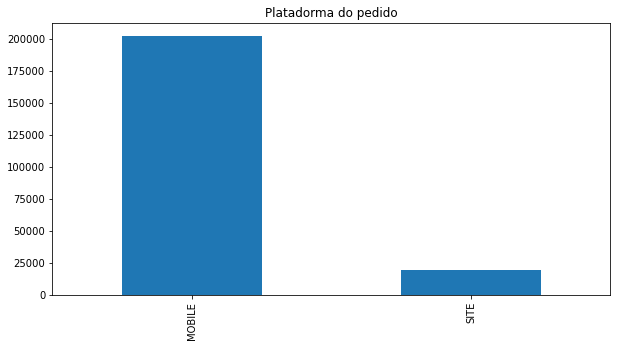

In [86]:
f, ax = plt.subplots(figsize=(10, 5))
df1.device_type.value_counts().plot(kind='bar', title="Platadorma do pedido", ax=ax, figsize=(10,5))
plt.show()

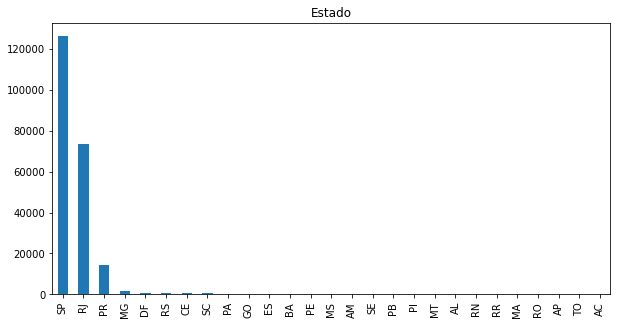

In [87]:
f, ax = plt.subplots(figsize=(10, 5))
df1.state_label.value_counts().plot(kind='bar', title="Estado", ax=ax, figsize=(10,5))
plt.show()

Aqui vamos tomar algumas decisões sobre os dados (manter os dados predominantes:
- Limitar a origem do pedido a apenas Restaurante
- Limitar ao agendamento a False
- Limitar os estados a SP e RJ

In [88]:
#Selecionando apenas restaurante
def listaFiltro(dataframe, valores):
    return dataframe.loc[dataframe['order_origin'].isin(valores)]
lista = ['RESTAURANT']
df2 = listaFiltro(df1, lista)
df2

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at;;,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date,primeiro_pedido,utilizacao_ifood
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,8.7500,False,53.7500,0.0,ANDROID,MOBILE,9.39.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,83c3e069dbd7267a7565a16b879cd968c0968a27ac16e6...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.38,RJ,RIO DE JANEIRO,PAVUNA,21650420.0,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-02-28T19:06:31.861Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
1,137fb568-2756-408d-94ed-d67e011bd101,weekday lunch,RESTAURANT,5.0000,False,46.2500,0.0,ANDROID,MOBILE,9.61.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,caea67d70fc15b47f91313697d74218975c595332ad3c7...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.35,RJ,RIO DE JANEIRO,Pavuna,21532440.0,-43.36,-22.82,False,2020-08-05T12:04:11.975Z,2020-08-05T13:58:07.939Z,4.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-08-05T16:59:05.170Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
2,4605cdab-de39-45c8-81aa-deb752039354,weekday lunch,RESTAURANT,11.2500,False,72.5000,0.0,ANDROID,MOBILE,9.47.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,fb61026e05c21f18bbd85fb17112f7e39a67fb69a76285...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.3,RJ,RIO DE JANEIRO,Cordovil,21010180.0,-43.30,-22.82,False,2020-04-22T12:23:32.554Z,2020-04-22T14:41:57.633Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-04-22T18:28:34.009Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
3,2244c745-4b28-4544-bbd6-4e1101fda966,weekday lunch,RESTAURANT,9.9875,False,73.2125,0.0,ANDROID,MOBILE,9.47.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,a10244c99caff623e5d1df2ed3c60b718c1692892790c6...,Doces & Bolos,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.79-43.36,RJ,SAO JOAO DE MERITI,JARDIM JOSE BONIFACIO,25565370.0,-43.37,-22.79,False,2020-04-23T14:17:16.606Z,2020-04-23T14:52:40.470Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-04-24T03:15:23.114Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
4,f4ebb4d5-f4b6-4799-bd8a-5f77aaec8d71,weekend dinner,RESTAURANT,14.9875,False,56.2375,0.0,ANDROID,MOBILE,9.42.2,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,4a6ee271e930ff43ded123ac235b7ab305f75f9b12bc59...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.8-43.39,RJ,SAO JOAO DE MERITI,Tomazinho,25525520.0,-43.40,-22.81,False,2020-03-15T18:43:35.517Z,2020-03-15T19:37:59.175Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-03-16T02:24:28.095Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221628,72092f74-7366-4afe-9e74-d575d679cc01,weekend lunch,RESTAURANT,0.0000,False,27.5000,0.0,ANDROID,MOBILE,9.39.1,-23.63-46.61,SP,SAO PAULO,Vila Moraes,-46.61,-23.64,5f731c493c83b9f845d0d6fd846c4698e23300d8aeb578...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.63-46.62,SP,SAO PAULO,Vila Brasilina,4161070.0,-46.62,-23.64,True,2020-03-01T11:55:18.737Z,2020-03-01T13:55:18.201Z,7.0,1df4e2cf-07c8-4d82-b830-5aa33505bf2f,5.0,10.0,2020-03-15T19:54:48.660Z;;,2018-02-07,Inactive,Inactive,11.0,2018-02

In [89]:
indexNames = df2[df2['scheduled'] == True].index
# Delete these row indexes from dataFrame
df2.drop(indexNames , inplace=True)
df2

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at;;,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date,primeiro_pedido,utilizacao_ifood
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,8.7500,False,53.7500,0.0,ANDROID,MOBILE,9.39.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,83c3e069dbd7267a7565a16b879cd968c0968a27ac16e6...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.38,RJ,RIO DE JANEIRO,PAVUNA,21650420.0,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-02-28T19:06:31.861Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
1,137fb568-2756-408d-94ed-d67e011bd101,weekday lunch,RESTAURANT,5.0000,False,46.2500,0.0,ANDROID,MOBILE,9.61.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,caea67d70fc15b47f91313697d74218975c595332ad3c7...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.35,RJ,RIO DE JANEIRO,Pavuna,21532440.0,-43.36,-22.82,False,2020-08-05T12:04:11.975Z,2020-08-05T13:58:07.939Z,4.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-08-05T16:59:05.170Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
2,4605cdab-de39-45c8-81aa-deb752039354,weekday lunch,RESTAURANT,11.2500,False,72.5000,0.0,ANDROID,MOBILE,9.47.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,fb61026e05c21f18bbd85fb17112f7e39a67fb69a76285...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.3,RJ,RIO DE JANEIRO,Cordovil,21010180.0,-43.30,-22.82,False,2020-04-22T12:23:32.554Z,2020-04-22T14:41:57.633Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-04-22T18:28:34.009Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
3,2244c745-4b28-4544-bbd6-4e1101fda966,weekday lunch,RESTAURANT,9.9875,False,73.2125,0.0,ANDROID,MOBILE,9.47.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,a10244c99caff623e5d1df2ed3c60b718c1692892790c6...,Doces & Bolos,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.79-43.36,RJ,SAO JOAO DE MERITI,JARDIM JOSE BONIFACIO,25565370.0,-43.37,-22.79,False,2020-04-23T14:17:16.606Z,2020-04-23T14:52:40.470Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-04-24T03:15:23.114Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
4,f4ebb4d5-f4b6-4799-bd8a-5f77aaec8d71,weekend dinner,RESTAURANT,14.9875,False,56.2375,0.0,ANDROID,MOBILE,9.42.2,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,4a6ee271e930ff43ded123ac235b7ab305f75f9b12bc59...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.8-43.39,RJ,SAO JOAO DE MERITI,Tomazinho,25525520.0,-43.40,-22.81,False,2020-03-15T18:43:35.517Z,2020-03-15T19:37:59.175Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-03-16T02:24:28.095Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221628,72092f74-7366-4afe-9e74-d575d679cc01,weekend lunch,RESTAURANT,0.0000,False,27.5000,0.0,ANDROID,MOBILE,9.39.1,-23.63-46.61,SP,SAO PAULO,Vila Moraes,-46.61,-23.64,5f731c493c83b9f845d0d6fd846c4698e23300d8aeb578...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.63-46.62,SP,SAO PAULO,Vila Brasilina,4161070.0,-46.62,-23.64,True,2020-03-01T11:55:18.737Z,2020-03-01T13:55:18.201Z,7.0,1df4e2cf-07c8-4d82-b830-5aa33505bf2f,5.0,10.0,2020-03-15T19:54:48.660Z;;,2018-02-07,Inactive,Inactive,11.0,2018-02

In [90]:
def listaFiltro(dataframe, valores):
    return dataframe.loc[dataframe['state_label'].isin(valores)]
lista = ['SP', 'RJ']
df2 = listaFiltro(df1, lista)
df2

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at;;,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date,primeiro_pedido,utilizacao_ifood
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,8.7500,False,53.7500,0.0,ANDROID,MOBILE,9.39.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,83c3e069dbd7267a7565a16b879cd968c0968a27ac16e6...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.38,RJ,RIO DE JANEIRO,PAVUNA,21650420.0,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-02-28T19:06:31.861Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
1,137fb568-2756-408d-94ed-d67e011bd101,weekday lunch,RESTAURANT,5.0000,False,46.2500,0.0,ANDROID,MOBILE,9.61.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,caea67d70fc15b47f91313697d74218975c595332ad3c7...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.35,RJ,RIO DE JANEIRO,Pavuna,21532440.0,-43.36,-22.82,False,2020-08-05T12:04:11.975Z,2020-08-05T13:58:07.939Z,4.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-08-05T16:59:05.170Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
2,4605cdab-de39-45c8-81aa-deb752039354,weekday lunch,RESTAURANT,11.2500,False,72.5000,0.0,ANDROID,MOBILE,9.47.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,fb61026e05c21f18bbd85fb17112f7e39a67fb69a76285...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.3,RJ,RIO DE JANEIRO,Cordovil,21010180.0,-43.30,-22.82,False,2020-04-22T12:23:32.554Z,2020-04-22T14:41:57.633Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-04-22T18:28:34.009Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
3,2244c745-4b28-4544-bbd6-4e1101fda966,weekday lunch,RESTAURANT,9.9875,False,73.2125,0.0,ANDROID,MOBILE,9.47.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,a10244c99caff623e5d1df2ed3c60b718c1692892790c6...,Doces & Bolos,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.79-43.36,RJ,SAO JOAO DE MERITI,JARDIM JOSE BONIFACIO,25565370.0,-43.37,-22.79,False,2020-04-23T14:17:16.606Z,2020-04-23T14:52:40.470Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-04-24T03:15:23.114Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
4,f4ebb4d5-f4b6-4799-bd8a-5f77aaec8d71,weekend dinner,RESTAURANT,14.9875,False,56.2375,0.0,ANDROID,MOBILE,9.42.2,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,4a6ee271e930ff43ded123ac235b7ab305f75f9b12bc59...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.8-43.39,RJ,SAO JOAO DE MERITI,Tomazinho,25525520.0,-43.40,-22.81,False,2020-03-15T18:43:35.517Z,2020-03-15T19:37:59.175Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8.0,2020-03-16T02:24:28.095Z;;,2019-06-10,Active,Active,216.0,2019-07-24,2019-07-24,536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221628,72092f74-7366-4afe-9e74-d575d679cc01,weekend lunch,RESTAURANT,0.0000,False,27.5000,0.0,ANDROID,MOBILE,9.39.1,-23.63-46.61,SP,SAO PAULO,Vila Moraes,-46.61,-23.64,5f731c493c83b9f845d0d6fd846c4698e23300d8aeb578...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.63-46.62,SP,SAO PAULO,Vila Brasilina,4161070.0,-46.62,-23.64,True,2020-03-01T11:55:18.737Z,2020-03-01T13:55:18.201Z,7.0,1df4e2cf-07c8-4d82-b830-5aa33505bf2f,5.0,10.0,2020-03-15T19:54:48.660Z;;,2018-02-07,Inactive,Inactive,11.0,2018-02

Selecionando apenas features de interesse.

In [91]:
df2.columns

Index(['order_id', 'order_shift', 'order_origin', 'delivery_fee', 'scheduled',
       'total_amount', 'subsidy_amount', 'device_platform', 'device_type',
       'device_app_version', 'centroid_id', 'state_label', 'city', 'district',
       'customer_long', 'customer_lat', 'restaurant_id', 'dish_type',
       'group_id', 'merchant_centroid_id', 'merchant_state', 'merchant_city',
       'merchant_district', 'merchant_zipcode', 'merchant_long',
       'merchant_lat', 'has_free_delivery', 'confirmed_date', 'concluded_date',
       'lag_last_order', 'account_id', 'review_score', 'nps_score',
       'review_created_at;;', 'registration_date', 'ifood_status',
       'ifood_status_last_month', 'total_order_count', 'first_order_date',
       'primeiro_pedido', 'utilizacao_ifood'],
      dtype='object')

In [92]:
df3 = df2[['delivery_fee', 'scheduled', 'total_amount', 'subsidy_amount', 'device_platform', 'device_type', 'has_free_delivery', 
           'lag_last_order', 'ifood_status_last_month', 'total_order_count', 'utilizacao_ifood']]

In [93]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200091 entries, 0 to 221632
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   delivery_fee             200091 non-null  float64
 1   scheduled                200091 non-null  object 
 2   total_amount             200091 non-null  float64
 3   subsidy_amount           200091 non-null  float64
 4   device_platform          200091 non-null  object 
 5   device_type              200091 non-null  object 
 6   has_free_delivery        200091 non-null  object 
 7   lag_last_order           200091 non-null  float64
 8   ifood_status_last_month  200091 non-null  object 
 9   total_order_count        200091 non-null  float64
 10  utilizacao_ifood         200091 non-null  float64
dtypes: float64(6), object(5)
memory usage: 18.3+ MB


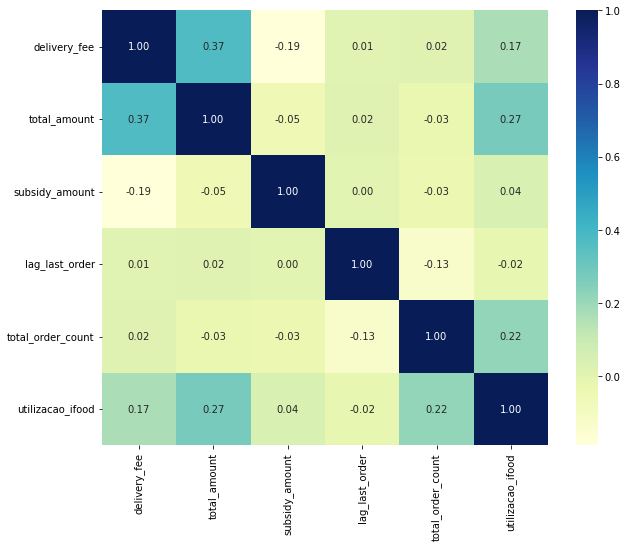

In [94]:
sns.set_context(font_scale=1.9)
plt.figure(figsize=(10,8))

sns.heatmap(
    df3.corr(), 
    annot=True,    
    fmt='.2f',    
    cmap='YlGnBu',   
)

plt.show()

#### Encoder

In [95]:
to_ohe = ['scheduled', 'device_platform', 'device_type', 'has_free_delivery', 'ifood_status_last_month']

ohe = OneHotEncoder(handle_unknown='error',sparse=False,drop="if_binary")

ohe_feat = ohe.fit_transform(df3.loc[:,to_ohe])
ohe_df = pd.DataFrame(ohe_feat, index=df3.index, columns=ohe.get_feature_names())
df4 = pd.concat([df3.drop(columns=to_ohe),ohe_df],axis=1)

In [96]:
df4

,delivery_fee,total_amount,subsidy_amount,lag_last_order,total_order_count,utilizacao_ifood,x0_True,x1_ANDROID,x1_DESKTOP,x1_IOS,x2_SITE,x3_True,x4_Active,x4_Churn,x4_Inactive,x4_Reactivated
0,8.7500,53.7500,0.0,1.0,216.0,536.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5.0000,46.2500,0.0,4.0,216.0,536.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,11.2500,72.5000,0.0,1.0,216.0,536.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,9.9875,73.2125,0.0,1.0,216.0,536.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,14.9875,56.2375,0.0,1.0,216.0,536.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221628,0.0000,27.5000,0.0,7.0,11.0,1067.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
221629,0.0000,60.5875,0.0,134.0,33.0,1106.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
221630,8.7375,59.9875,0.0,1.0,551.0,1711.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
221631,12.5000,49.8750,0.0,13.0,340.0,1355.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


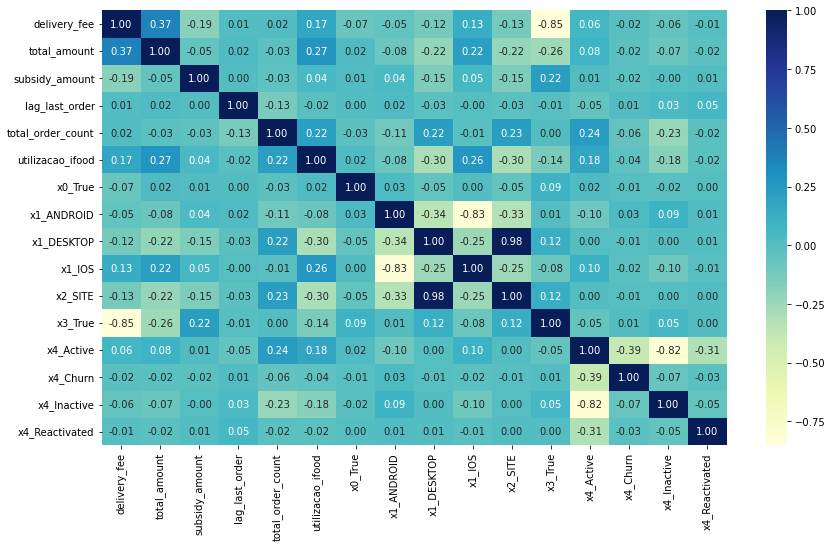

In [99]:
sns.set_context(font_scale=1.9)
plt.figure(figsize=(14,8))

sns.heatmap(
    df4.corr(), 
    annot=True,    
    fmt='.2f',    
    cmap='YlGnBu',   
)
plt.show()

In [101]:
df4.describe() #Necessita normalização

,delivery_fee,total_amount,subsidy_amount,lag_last_order,total_order_count,utilizacao_ifood,x0_True,x1_ANDROID,x1_DESKTOP,x1_IOS,x2_SITE,x3_True,x4_Active,x4_Churn,x4_Inactive,x4_Reactivated
count,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000,200091.000000
mean,4.043559,60.662946,3.455996,2.503736,545.692725,1247.900925,0.025214,0.531253,0.092548,0.376199,0.095801,0.526925,0.824275,0.030646,0.124698,0.020381
std,5.009716,52.246583,6.827008,12.073508,356.741794,701.247196,0.156773,0.499024,0.289799,0.484432,0.294319,0.499276,0.380587,0.172357,0.330377,0.141299
min,-12.475000,0.000000,-0.025000,0.000000,2.000000,316.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.125000,0.000000,0.000000,305.000000,598.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,45.625000,0.000000,1.000000,478.000000,1118.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,7.487500,76.237500,6.237500,2.000000,701.000000,1765.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,50.000000,1748.737500,196.112500,1429.000000,3098.000000,3297.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
from sklearn.preprocessing import StandardScaler

In [103]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df4)

In [114]:
df_s = pd.DataFrame(scaled_df)

In [115]:
df_s

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.939465,-0.132314,-0.506225,-0.124549,-0.924180,-1.015195,-0.160828,0.939330,-0.319353,-0.776579,-0.325502,-1.055382,0.461722,-0.177806,-0.377443,-0.144238
1,0.190918,-0.275865,-0.506225,0.123930,-0.924180,-1.015195,-0.160828,0.939330,-0.319353,-0.776579,-0.325502,-1.055382,0.461722,-0.177806,-0.377443,-0.144238
2,1.438496,0.226562,-0.506225,-0.124549,-0.924180,-1.015195,-0.160828,0.939330,-0.319353,-0.776579,-0.325502,-1.055382,0.461722,-0.177806,-0.377443,-0.144238
3,1.186485,0.240199,-0.506225,-0.124549,-0.924180,-1.015195,-0.160828,0.939330,-0.319353,-0.776579,-0.325502,-1.055382,0.461722,-0.177806,-0.377443,-0.144238
4,2.184548,-0.084703,-0.506225,-0.124549,-0.924180,-1.015195,-0.160828,0.939330,-0.319353,-0.776579,-0.325502,-1.055382,0.461722,-0.177806,-0.377443,-0.144238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200086,-0.807145,-0.634741,-0.506225,0.372408,-1.498827,-0.257971,-0.160828,0.939330,-0.319353,-0.776579,-0.325502,0.947524,-2.165804,-0.177806,2.649407,-0.144238
200087,-0.807145,-0.001444,-0.506225,10.891333,-1.437157,-0.202356,-0.160828,-1.064588,-0.319353,1.287699,-0.325502,0.947524,-2.165804,-0.177806,2.649407,-0.144238
200088,0.936970,-0.012928,-0.506225,-0.124549,0.014877,0.660395,-0.160828,-1.064588,-0.319353,1.287699,-0.325502,-1.055382,0.461722,-0.177806,-0.377443,-0.144238
200089,1.688012,-0.206482,-0.506225,0.869365,-0.576589,0.152727,-0.160828,0.939330,-0.319353,-0.776579,-0.325502,-1.055382,0.461722,-0.177806,-0.377443,-0.144238


## Produtização

In [105]:
# Plotar a inércia para os n clusters usados.

#escolher até a quantidade maxima de clusters que deseja testar
range_clust = list(range(1,6))
inertia = []
for n_clus in range_clust:  # iterar sobre o intervalo de ncluster desejado
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=10, random_state=42)
    kmclust.fit(df4)
    inertia.append(kmclust.inertia_)  # salva a inércia da solução de cluster fornecida

inertia = dict(zip(range_clust,inertia))

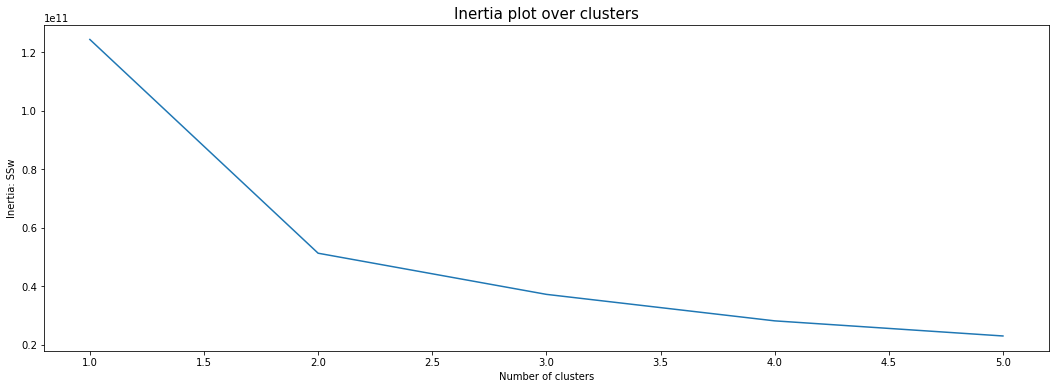

In [106]:
# O plot da inércia
plt.figure(figsize=(18,6))
plt.plot(pd.Series(inertia))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.5106255644513716
For n_clusters = 3, the average silhouette_score is : 0.4171865469145481
For n_clusters = 4, the average silhouette_score is : 0.4235218095106927
For n_clusters = 5, the average silhouette_score is : 0.39107989820990496


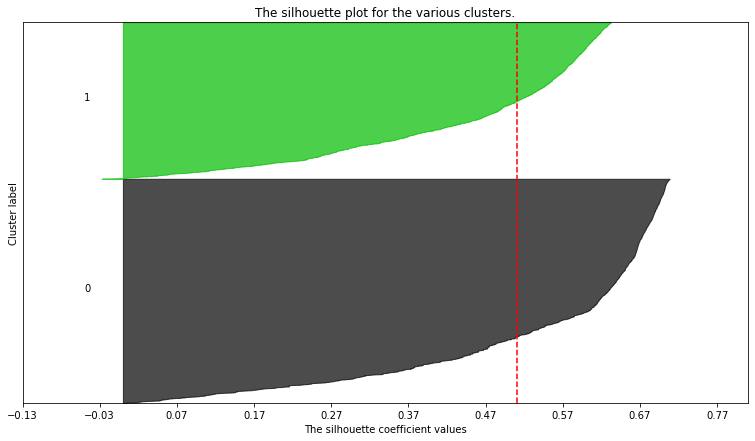

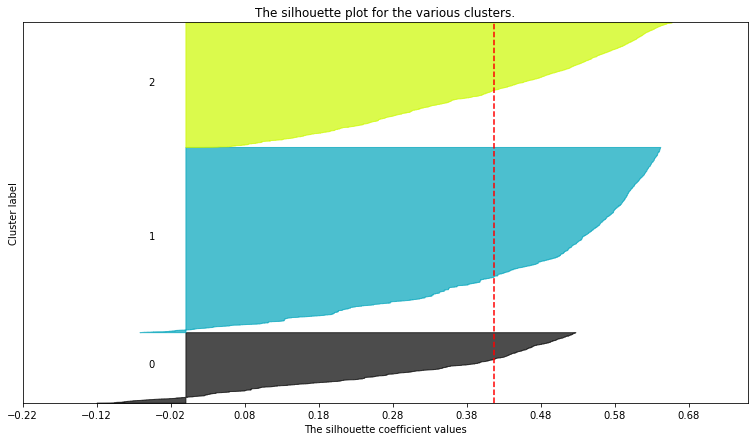

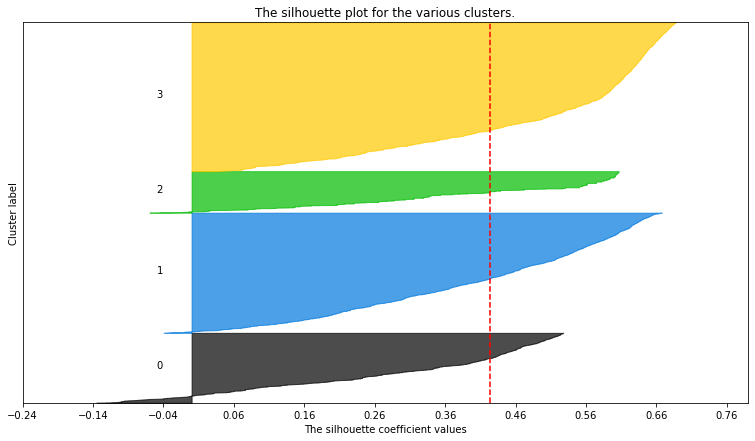

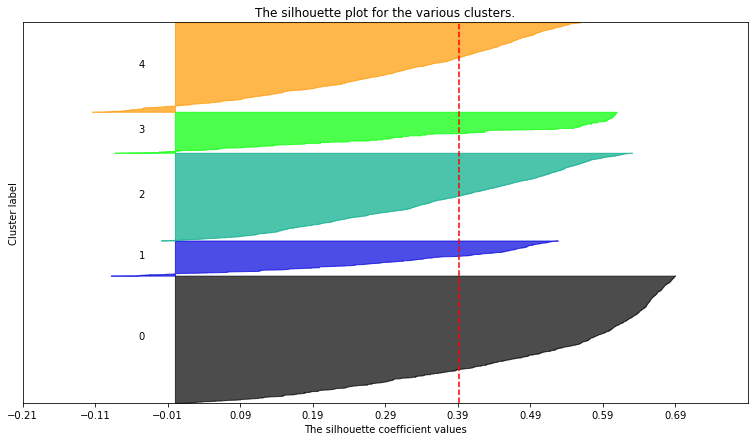

In [109]:
## Silhouette score

# Aadptado de:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

df_sill = df4.copy()

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clust:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmclust.fit_predict(df_sill)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_sill, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_sill, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_sill) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

In [121]:
## Esta célula é usada para definir a escolha de k, o número de clusters.
n_clusters = 4

In [122]:
# Aplique kmeans para o número de clusters definidos.
kmclust = KMeans(n_clusters=n_clusters, init='k-means++', n_init=5, random_state=42,verbose=0)
km_labels = kmclust.fit_predict(df_s)

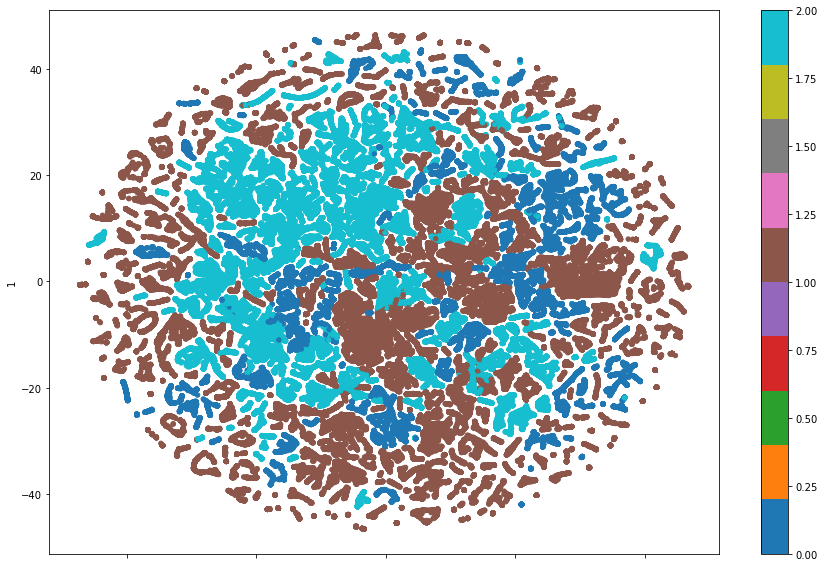

In [112]:
df_TSNE = TSNE().fit_transform(df4)
pd.DataFrame(df_TSNE).plot.scatter(x=0, y=1, c=km_labels, colormap='tab10', figsize=(15,10))
plt.show()

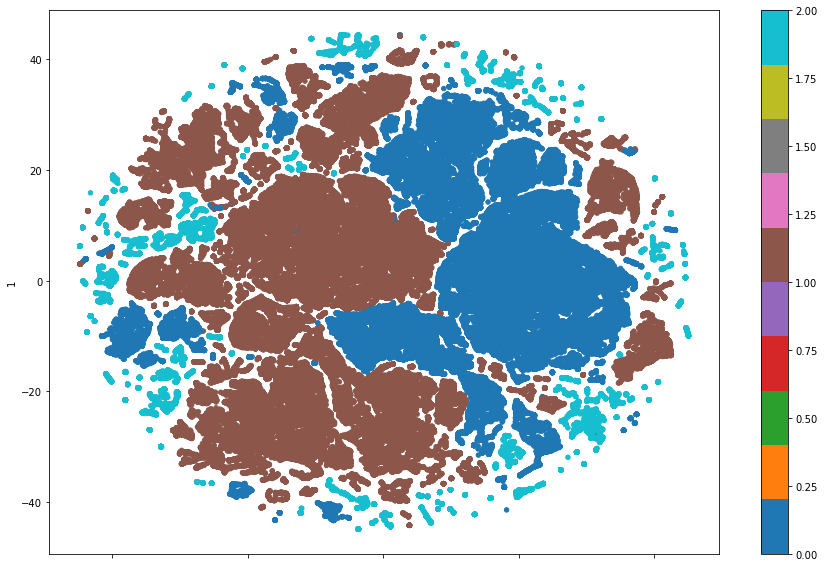

In [117]:
#3 clusters
df_TSNE = TSNE().fit_transform(df_s)
pd.DataFrame(df_TSNE).plot.scatter(x=0, y=1, c=km_labels, colormap='tab10', figsize=(15,10))
plt.show()

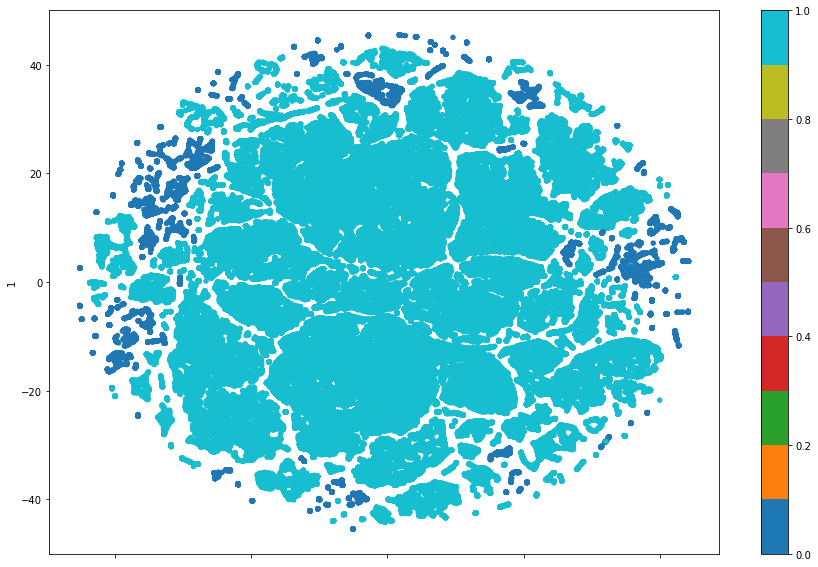

In [120]:
# 2 clusters
df_TSNE = TSNE().fit_transform(df_s)
pd.DataFrame(df_TSNE).plot.scatter(x=0, y=1, c=km_labels, colormap='tab10', figsize=(15,10))
plt.show()

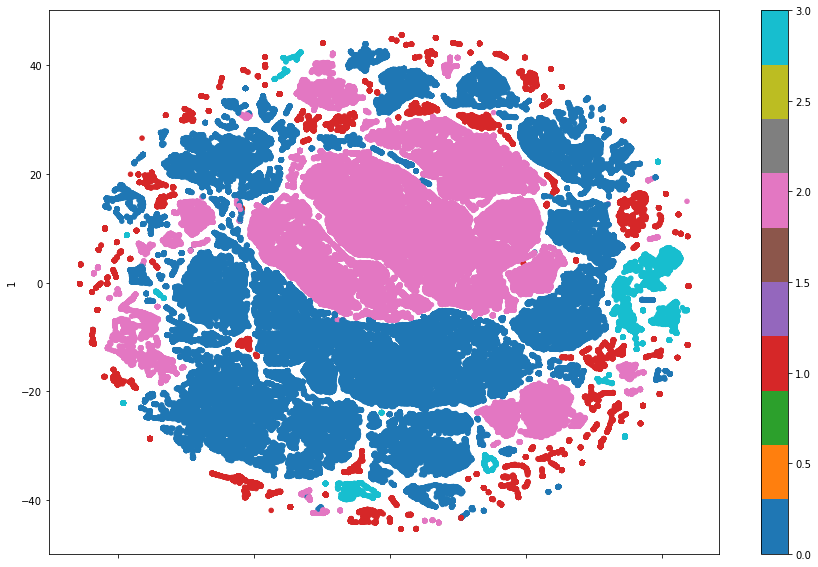

In [123]:
# 4 clusters
df_TSNE = TSNE().fit_transform(df_s)
pd.DataFrame(df_TSNE).plot.scatter(x=0, y=1, c=km_labels, colormap='tab10', figsize=(15,10))
plt.show()

In [142]:
df3['labels'] = km_labels

In [143]:
df3.groupby(['labels']).mean()

,delivery_fee,total_amount,subsidy_amount,lag_last_order,total_order_count,utilizacao_ifood
labels,,,,,,
0,3.812391,56.595082,3.735762,2.686810,511.236504,1203.475326
1,2.057532,24.790842,0.213823,1.222519,802.166195,599.137571
2,4.902119,75.917207,3.948265,2.484526,539.577766,1484.168539
3,3.579625,53.519174,2.619284,3.520711,424.719993,1106.636986


## EDA após cluster

In [144]:
# Distribuição da variável device_platform
df3[["device_platform"]].value_counts()

device_platform
ANDROID            106299
IOS                 75274
DESKTOP             18518
dtype: int64

<AxesSubplot:xlabel='device_platform', ylabel='count'>

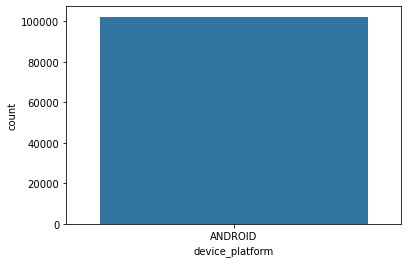

In [146]:
plataforma = df3['labels'] == 0
df_plataforma = df3[plataforma]
df_plataforma['device_platform']
sns.countplot(df_plataforma['device_platform'])

<AxesSubplot:xlabel='device_platform', ylabel='count'>

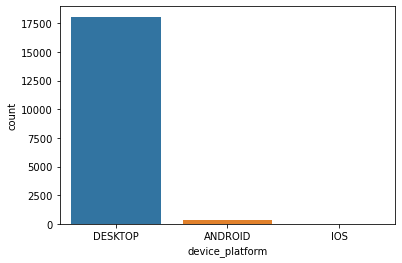

In [147]:
plataforma = df3['labels'] == 1
df_plataforma = df3[plataforma]
df_plataforma['device_platform']
sns.countplot(df_plataforma['device_platform'])

<AxesSubplot:xlabel='device_platform', ylabel='count'>

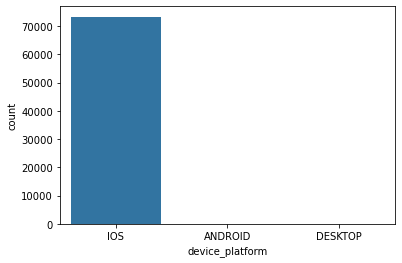

In [148]:
plataforma = df3['labels'] == 2
df_plataforma = df3[plataforma]
df_plataforma['device_platform']
sns.countplot(df_plataforma['device_platform'])

<AxesSubplot:xlabel='device_platform', ylabel='count'>

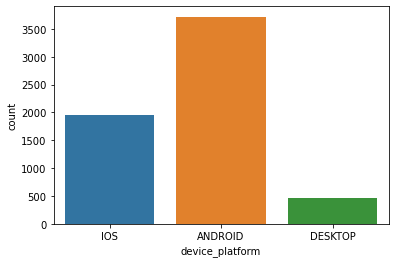

In [149]:
plataforma = df3['labels'] == 3
df_plataforma = df3[plataforma]
df_plataforma['device_platform']
sns.countplot(df_plataforma['device_platform'])

In [150]:
# Distribuição da variável has_free_delivery
df3[["has_free_delivery"]].value_counts()

has_free_delivery
True                 105433
False                 94658
dtype: int64

<AxesSubplot:xlabel='has_free_delivery', ylabel='count'>

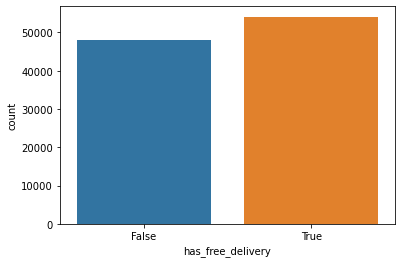

In [152]:
freedelivery = df3['labels'] == 0
df_freedelivery = df3[freedelivery]
df_freedelivery['has_free_delivery']
sns.countplot(df_freedelivery['has_free_delivery'])

<AxesSubplot:xlabel='has_free_delivery', ylabel='count'>

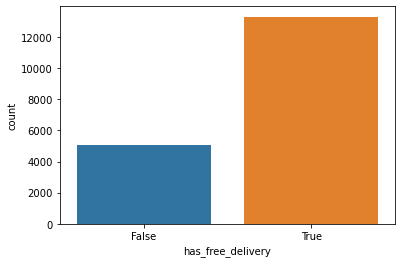

In [153]:
freedelivery = df3['labels'] == 1
df_freedelivery = df3[freedelivery]
df_freedelivery['has_free_delivery']
sns.countplot(df_freedelivery['has_free_delivery'])

<AxesSubplot:xlabel='has_free_delivery', ylabel='count'>

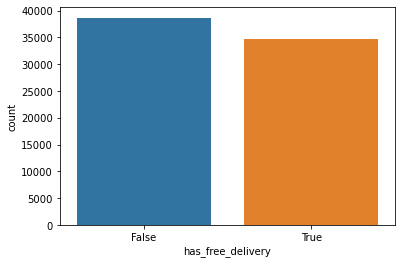

In [154]:
freedelivery = df3['labels'] == 2
df_freedelivery = df3[freedelivery]
df_freedelivery['has_free_delivery']
sns.countplot(df_freedelivery['has_free_delivery'])

<AxesSubplot:xlabel='has_free_delivery', ylabel='count'>

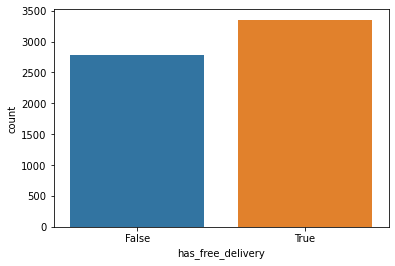

In [155]:
freedelivery = df3['labels'] == 3
df_freedelivery = df3[freedelivery]
df_freedelivery['has_free_delivery']
sns.countplot(df_freedelivery['has_free_delivery'])

In [157]:
# Distribuição da variável ifood_status
df3[["ifood_status_last_month"]].value_counts()

ifood_status_last_month
Active                     164930
Inactive                    24951
Churn                        6132
Reactivated                  4078
dtype: int64

<AxesSubplot:xlabel='ifood_status_last_month', ylabel='count'>

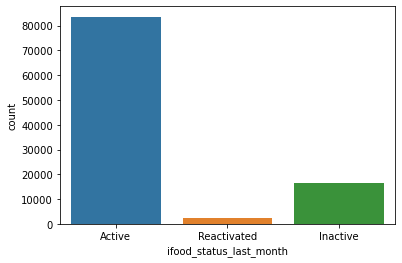

In [159]:
ifoodstatus = df3['labels'] == 0
df_ifoodstatus = df3[ifoodstatus]
df_ifoodstatus['ifood_status_last_month']
sns.countplot(df_ifoodstatus['ifood_status_last_month'])

<AxesSubplot:xlabel='ifood_status', ylabel='count'>

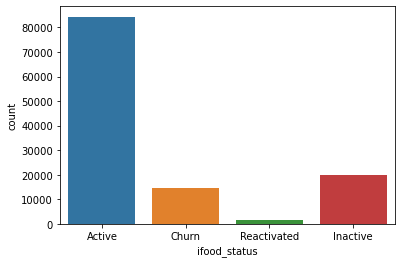

In [88]:
ifoodstatus = df3['labels'] == 0
df_ifoodstatus = df3[ifoodstatus]
df_ifoodstatus['ifood_status_last_month']
sns.countplot(df_ifoodstatus['ifood_status_last_month'])

<AxesSubplot:xlabel='ifood_status', ylabel='count'>

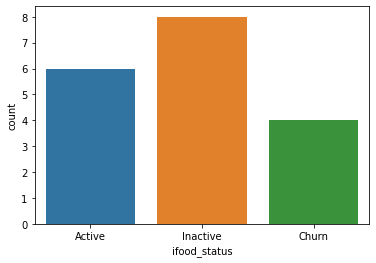

In [89]:
ifoodstatus = df2['clusters'] == 2
df_ifoodstatus = df2[ifoodstatus]
df_ifoodstatus['ifood_status']
sns.countplot(df_ifoodstatus['ifood_status'])

<AxesSubplot:xlabel='ifood_status', ylabel='count'>

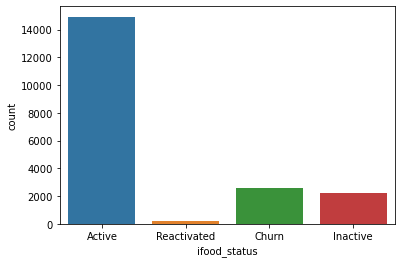

In [90]:
ifoodstatus = df2['clusters'] == 3
df_ifoodstatus = df2[ifoodstatus]
df_ifoodstatus['ifood_status']
sns.countplot(df_ifoodstatus['ifood_status'])

<AxesSubplot:xlabel='ifood_status', ylabel='count'>

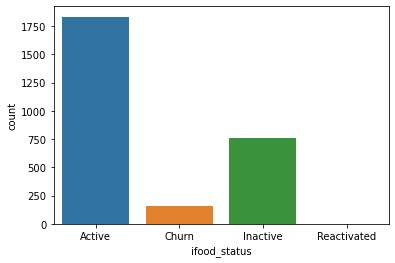

In [91]:
ifoodstatus = df2['clusters'] == 4
df_ifoodstatus = df2[ifoodstatus]
df_ifoodstatus['ifood_status']
sns.countplot(df_ifoodstatus['ifood_status'])

<AxesSubplot:xlabel='ifood_status', ylabel='count'>

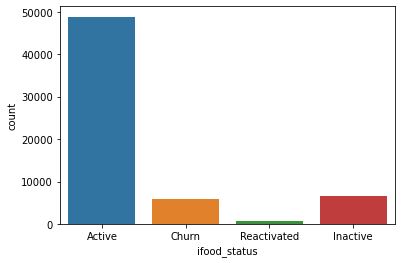

In [92]:
ifoodstatus = df2['clusters'] == 5
df_ifoodstatus = df2[ifoodstatus]
df_ifoodstatus['ifood_status']
sns.countplot(df_ifoodstatus['ifood_status'])

In [93]:
# Distribuição da variável order_shift
df2[["order_shift"]].value_counts()

order_shift      
weekday lunch        57340
weekday dinner       52881
weekend dinner       50240
weekend lunch        22571
weekday snack        13139
weekday breakfast    11159
weekend snack         5860
weekday dawn          3597
weekend dawn          3193
weekend breakfast     1653
dtype: int64

<AxesSubplot:xlabel='order_shift', ylabel='count'>

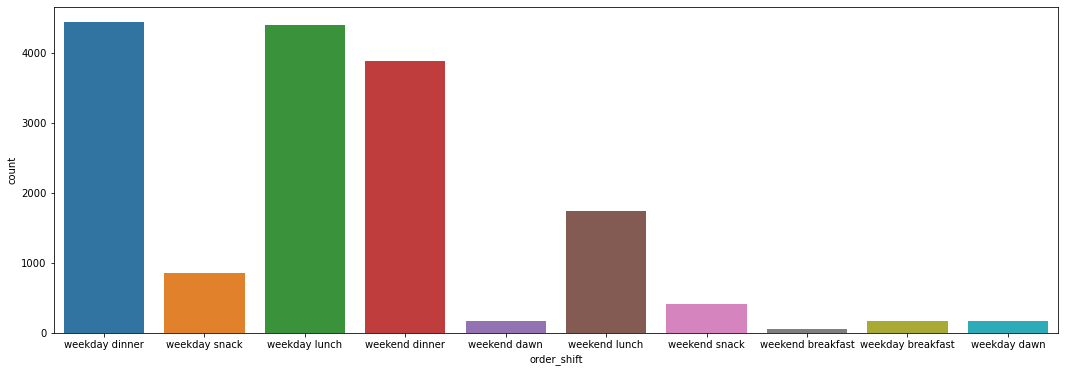

In [94]:
plt.figure(figsize=(18,6))
pedido = df2['clusters'] == 0
df_pedido = df2[pedido]
df_pedido['order_shift']
sns.countplot(df_pedido['order_shift'])

<AxesSubplot:xlabel='order_shift', ylabel='count'>

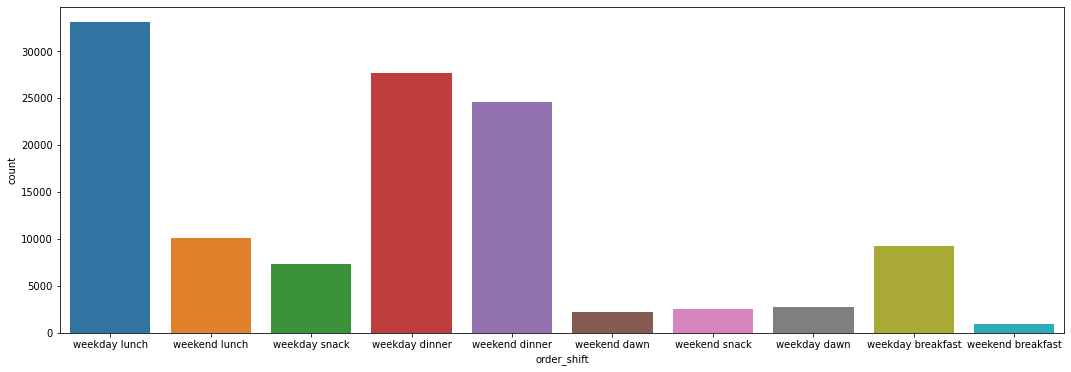

In [95]:
plt.figure(figsize=(18,6))
pedido = df2['clusters'] == 1
df_pedido = df2[pedido]
df_pedido['order_shift']
sns.countplot(df_pedido['order_shift'])

<AxesSubplot:xlabel='order_shift', ylabel='count'>

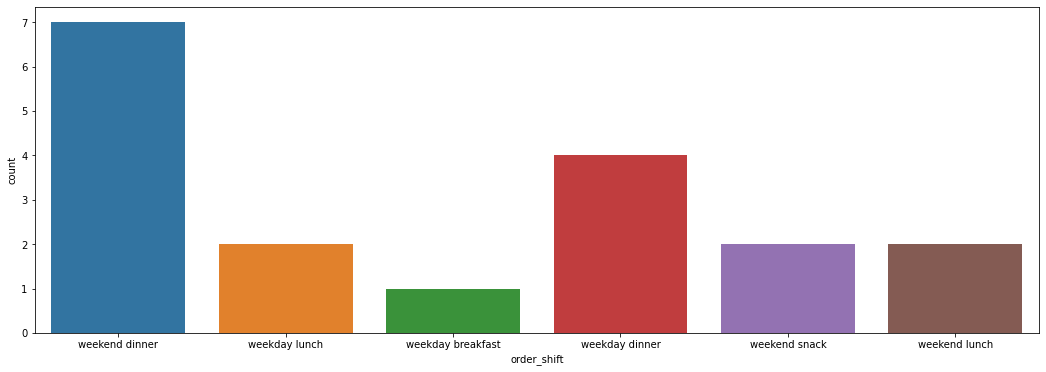

In [96]:
plt.figure(figsize=(18,6))
pedido = df2['clusters'] == 2
df_pedido = df2[pedido]
df_pedido['order_shift']
sns.countplot(df_pedido['order_shift'])

<AxesSubplot:xlabel='order_shift', ylabel='count'>

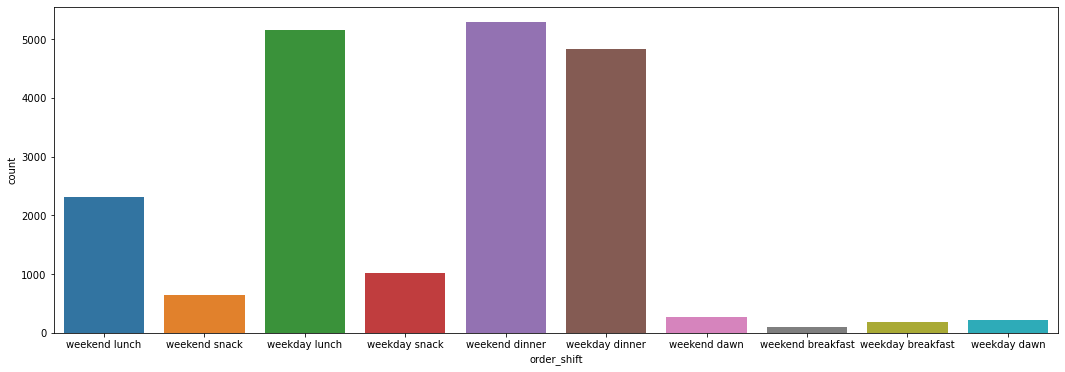

In [97]:
plt.figure(figsize=(18,6))
pedido = df2['clusters'] == 3
df_pedido = df2[pedido]
df_pedido['order_shift']
sns.countplot(df_pedido['order_shift'])

<AxesSubplot:xlabel='order_shift', ylabel='count'>

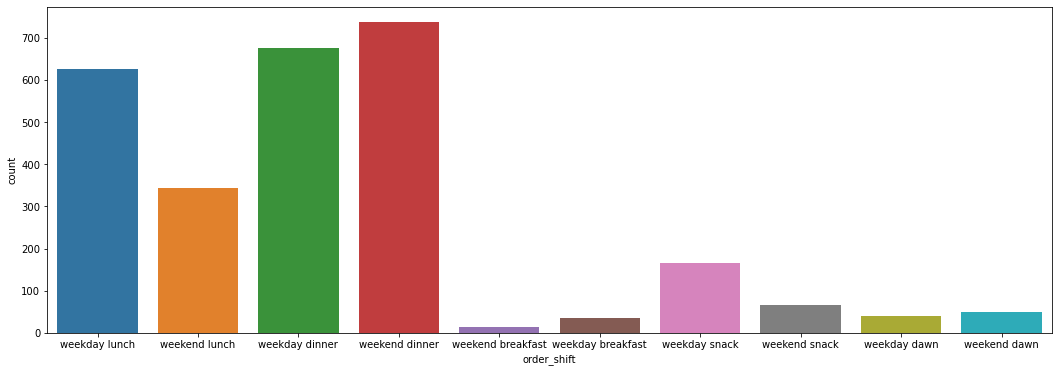

In [98]:
plt.figure(figsize=(18,6))
pedido = df2['clusters'] == 4
df_pedido = df2[pedido]
df_pedido['order_shift']
sns.countplot(df_pedido['order_shift'])

<AxesSubplot:xlabel='order_shift', ylabel='count'>

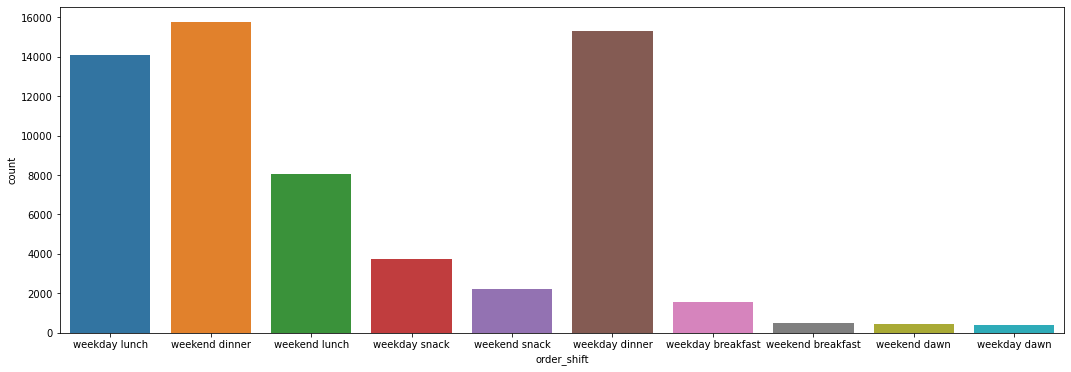

In [99]:
plt.figure(figsize=(18,6))
pedido = df2['clusters'] == 5
df_pedido = df2[pedido]
df_pedido['order_shift']
sns.countplot(df_pedido['order_shift'])

### Personas

Foram encontrados 6 tipos de personas:

**0** Clientes que gastam em média 60,00 e pagam uma taxa de entrega de 4,25, utilizam mais Android que IOS, utilizam mais entrega grátis apesar de não diferir muito, são em maioria usuários ativos no ifood, costumam fazer pedidos durante a semana para almoço e jantar e no final de semana para o jantar.

**1** Clientes que gastam em média 41,00 e pagam uma taxa de entrega de 1,00, utilizam mais Android que IOS (e alguns utilizam Desktop), utilizam muito mais entrega grátis, são em maioria usuários ativos no ifood, costumam fazer pedidos durante a semana para almoço e jantar e no final de semana para o jantar.

**2** Clientes que gastam em média 56,00 e pagam uma taxa de entrega de 3,30, utilizam mais Android que IOS, utilizam mais entrega grátis, diferentemente dos demais são em maioria usuários inativos no ifood, costumam fazer pedidos principalmente durante ao fim de semana para jantar e durante a semana no jantar.

**3** Clientes que gastam em média 70,00 e pagam uma taxa de entrega de 4,60, utilizam mais Android que IOS, não diferem muito no tipo de entrega, são em maioria usuários ativos no ifood, costumam fazer pedidos principalmente durante a semana para o almoço e jantar e durante o fim de semana no jantar.

**4** Clientes que gastam em média 66,00 e pagam uma taxa de entrega de 5,00, diferentemente dos demais, utilizam mais IOS que Android, não diferem muito no tipo de entrega e utilizam mais entregas com pagamento de delivery , são em maioria usuários ativos no ifood, costumam fazer pedidos principalmente durante a semana para o almoço e jantar e durante o fim de semana no jantar.

**5** Clientes que mais gastam, em média 95,00 e pagam taxa de entrega mais alta, de 9,60, não diferem entre uso de IOS e Android, maioria não utiliza entrega grátis, são em maioria usuários ativos no ifood, costumam fazer pedidos principalmente durante a semana para o almoço e jantar e durante o fim de semana no jantar.